# Código para o método PROMETHEE-Score

iniciarei importando algumas bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from PROMETHEE import PROMETHEE_2

In [2]:
dados = pd.read_excel("dados.xlsx", index_col=0)
dados = dados.dropna(axis=0)
dados.loc["Hong Kong"]

Property Rights           93.3
Judical Effectiveness     75.3
Government Integrity      83.8
Tax Burden                93.1
Gov't Spending            90.3
Fiscal Health            100.0
Business Freedom          96.4
Labor Freedom             89.2
Monetary Freedom          86.4
Trade Freedom             95.0
Investment Freedom        90.0
Financial Freedom         90.0
Name: Hong Kong, dtype: float64

In [3]:
X = np.array(dados) # decision matrix
m, n = X.shape
q = np.array([5 for j in range (n)]) # indiference thresholds vector
p = np.array([10 for j in range (n)]) # preference thresholds vector
s_curve = [0 for j in range (n)]
pref = [5 for j in range (n)]
w = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights

In [4]:
# Aplica o PROMETHEE_2 ao nosso conjunto de dados

net_flows = PROMETHEE_2(Decision_Matrix = X, q_thresholds=q, p_thresholds= p, scurve_thresholds = s_curve, weights = w, pref_functions= pref)[1]

In [5]:
pd.DataFrame(net_flows, index=dados.index).loc["Hong Kong"]

0    0.869281
Name: Hong Kong, dtype: float64

### SMAA

- Vamos agora rodar o PROMETHEE no mesmo conjunto de dados, porém, usaremos variáveis aleatórias.

In [6]:
n_simulations = 30

W = np.zeros(shape = (n, n_simulations))
P = np.zeros(shape = (n, n_simulations))
Q = np.zeros(shape = (n, n_simulations))

Net_Flows = np.zeros(shape = (m, n_simulations))
Pos_Flows = np.zeros(shape = (m, n_simulations))
Neg_Flows = np.zeros(shape = (m, n_simulations))
results = [[] for s in range (n_simulations)]

# Usaremos sempre a função de preferência do tipo 5
s_curve = [0 for j in range (n)] 
pref = [5 for j in range (n)]

for s in range (n_simulations):
    W [:,s] = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights
    Q [:,s] = np.random.uniform (2,6, n)
    P [:,s] = np.random.uniform (8, 12, n)
    results[s], Net_Flows[:,s], Pos_Flows[:,s], Neg_Flows[:,s] = PROMETHEE_2 (X, Q[:,s], P[:,s], s_curve, W[:,s], pref)
    print (f'simulation {s+1} completed')

simulation 1 completed
simulation 2 completed
simulation 3 completed
simulation 4 completed
simulation 5 completed
simulation 6 completed
simulation 7 completed
simulation 8 completed
simulation 9 completed
simulation 10 completed
simulation 11 completed
simulation 12 completed
simulation 13 completed
simulation 14 completed
simulation 15 completed
simulation 16 completed
simulation 17 completed
simulation 18 completed
simulation 19 completed
simulation 20 completed
simulation 21 completed
simulation 22 completed
simulation 23 completed
simulation 24 completed
simulation 25 completed
simulation 26 completed
simulation 27 completed
simulation 28 completed
simulation 29 completed
simulation 30 completed


In [7]:
mu_net = np.mean(Net_Flows, axis=1)
sigma_net = np.std(Net_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_net,"Mu": mu_net}, index= dados.index)
Sigma_Mu_df.columns


Index(['Sigma', 'Mu'], dtype='object')

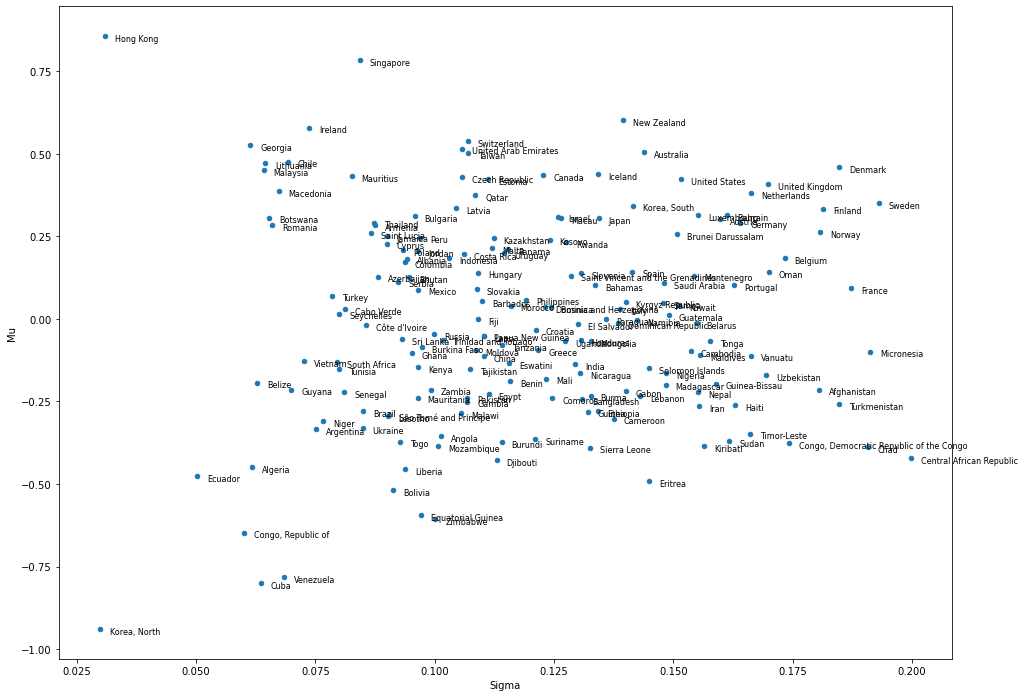

In [8]:
from matplotlib import cm

fig, ax = plt.subplots()

cmap = cm.get_cmap('Spectral')

Sigma_Mu_df.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (16,12))

for k, v in Sigma_Mu_df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='black')

In [9]:
# Possívei ideia de usar KMeans antes da otimização
"""
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(Sigma_Mu_df)
kmeans.labels_

Sigma_Mu_df.assign(Category = kmeans.labels_)

Sigma_Mu_df_clusters = Sigma_Mu_df.assign(Category = kmeans.labels_)
Sigma_Mu_df_clusters
"""

'\nfrom sklearn.cluster import KMeans\nkmeans = KMeans(n_clusters=3, random_state=0).fit(Sigma_Mu_df)\nkmeans.labels_\n\nSigma_Mu_df.assign(Category = kmeans.labels_)\n\nSigma_Mu_df_clusters = Sigma_Mu_df.assign(Category = kmeans.labels_)\nSigma_Mu_df_clusters\n'

### PKFs 

In the cell below, I'll obtain the PKFs for the Sigma-Mu plot 

In [10]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1



PKF_1: ['Hong Kong', 'Korea, North ']
PKF_2: ['Ecuador', 'Georgia', 'Ireland', 'Singapore']
PKF_3: ['Algeria', 'Belize', 'Chile', 'Congo, Republic of', 'Lithuania', 'Malaysia', 'New Zealand', 'Switzerland', 'United Arab Emirates']
PKF_4: ['Australia', 'Botswana', 'Cuba', 'Macedonia', 'Mauritius', 'Taiwan ']
PKF_5: ['Bulgaria', 'Canada', 'Czech Republic', 'Denmark', 'Iceland', 'Latvia', 'Romania', 'Thailand']
PKF_6: ['Armenia', 'Estonia', 'Guyana', 'Qatar', 'Saint Lucia', 'Turkey', 'United States', 'Venezuela', 'Vietnam']
PKF_7: ['Argentina', 'Azerbaijan', 'Cabo Verde', 'Israel', 'Jamaica', 'Korea, South', 'Netherlands', 'Niger', 'Seychelles', 'South Africa', 'United Kingdom']
PKF_8: ['Bahrain', "Côte d'Ivoire", 'Cyprus', 'Finland', 'Luxembourg', 'Macau', 'Peru', 'Sweden', 'Tunisia']
PKF_9: ['Japan', 'Kazakhstan', 'Malta', 'Poland', 'Senegal', 'Serbia']
PKF_10: ['Albania', 'Austria', 'Brazil', 'Brunei Darussalam', 'Colombia', 'Jordan', 'Kosovo', 'Panama', 'Sri Lanka', 'Ukraine']
PKF_11:

### Otimização

O Score das alternativas é obtido através de um modelo de otimização linear.

In [11]:
from PROMETHEE import optimize_PROM2_original, optimize_newconstraint

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[PKF[fr]]) # get alternatives within frontier fr
        
        M, resultado = optimize_PROM2_original(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')
        
        #print(f'local_ef = {local_ef[unit, fr]}')


alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 1, fronteira 6: resolvido.
alternative 1, fronteira 7: resolvido.
alternative 1, fronteira 8: resolvido.
alternative 1, fronteira 9: resolvido.
alternative 1, fronteira 10: resolvido.
alternative 1, fronteira 11: resolvido.
alternative 1, fronteira 12: resolvido.
alternative 1, fronteira 13: resolvido.
alternative 1, fronteira 14: resolvido.
alternative 1, fronteira 15: resolvido.
alternative 1, fronteira 16: resolvido.
alternative 1, fronteira 17: resolvido.
alternative 1, fronteira 18: resolvido.
alternative 1, fronteira 19: resolvido.
alternative 1, fronteira 20: resolvido.
alternative 1, fronteira 21: resolvido.
alternative 1, fronteira 22: resolvido.
alternative 1, fronteira 23: resolvido.
alternative 1, fronteira 24: resolvido.
alternative 1, fronteira 25: resolvido.
alternati

alternative 8, fronteira 19: resolvido.
alternative 8, fronteira 20: resolvido.
alternative 8, fronteira 21: resolvido.
alternative 8, fronteira 22: resolvido.
alternative 8, fronteira 23: resolvido.
alternative 8, fronteira 24: resolvido.
alternative 8, fronteira 25: resolvido.
alternative 8, fronteira 26: resolvido.
alternative 8, fronteira 27: resolvido.
alternative 9, fronteira 1: resolvido.
alternative 9, fronteira 2: resolvido.
alternative 9, fronteira 3: resolvido.
alternative 9, fronteira 4: resolvido.
alternative 9, fronteira 5: resolvido.
alternative 9, fronteira 6: resolvido.
alternative 9, fronteira 7: resolvido.
alternative 9, fronteira 8: resolvido.
alternative 9, fronteira 9: resolvido.
alternative 9, fronteira 10: resolvido.
alternative 9, fronteira 11: resolvido.
alternative 9, fronteira 12: resolvido.
alternative 9, fronteira 13: resolvido.
alternative 9, fronteira 14: resolvido.
alternative 9, fronteira 15: resolvido.
alternative 9, fronteira 16: resolvido.
alternati

alternative 16, fronteira 6: resolvido.
alternative 16, fronteira 7: resolvido.
alternative 16, fronteira 8: resolvido.
alternative 16, fronteira 9: resolvido.
alternative 16, fronteira 10: resolvido.
alternative 16, fronteira 11: resolvido.
alternative 16, fronteira 12: resolvido.
alternative 16, fronteira 13: resolvido.
alternative 16, fronteira 14: resolvido.
alternative 16, fronteira 15: resolvido.
alternative 16, fronteira 16: resolvido.
alternative 16, fronteira 17: resolvido.
alternative 16, fronteira 18: resolvido.
alternative 16, fronteira 19: resolvido.
alternative 16, fronteira 20: resolvido.
alternative 16, fronteira 21: resolvido.
alternative 16, fronteira 22: resolvido.
alternative 16, fronteira 23: resolvido.
alternative 16, fronteira 24: resolvido.
alternative 16, fronteira 25: resolvido.
alternative 16, fronteira 26: resolvido.
alternative 16, fronteira 27: resolvido.
alternative 17, fronteira 1: resolvido.
alternative 17, fronteira 2: resolvido.
alternative 17, fronte

alternative 23, fronteira 19: resolvido.
alternative 23, fronteira 20: resolvido.
alternative 23, fronteira 21: resolvido.
alternative 23, fronteira 22: resolvido.
alternative 23, fronteira 23: resolvido.
alternative 23, fronteira 24: resolvido.
alternative 23, fronteira 25: resolvido.
alternative 23, fronteira 26: resolvido.
alternative 23, fronteira 27: resolvido.
alternative 24, fronteira 1: resolvido.
alternative 24, fronteira 2: resolvido.
alternative 24, fronteira 3: resolvido.
alternative 24, fronteira 4: resolvido.
alternative 24, fronteira 5: resolvido.
alternative 24, fronteira 6: resolvido.
alternative 24, fronteira 7: resolvido.
alternative 24, fronteira 8: resolvido.
alternative 24, fronteira 9: resolvido.
alternative 24, fronteira 10: resolvido.
alternative 24, fronteira 11: resolvido.
alternative 24, fronteira 12: resolvido.
alternative 24, fronteira 13: resolvido.
alternative 24, fronteira 14: resolvido.
alternative 24, fronteira 15: resolvido.
alternative 24, fronteira

alternative 31, fronteira 5: resolvido.
alternative 31, fronteira 6: resolvido.
alternative 31, fronteira 7: resolvido.
alternative 31, fronteira 8: resolvido.
alternative 31, fronteira 9: resolvido.
alternative 31, fronteira 10: resolvido.
alternative 31, fronteira 11: resolvido.
alternative 31, fronteira 12: resolvido.
alternative 31, fronteira 13: resolvido.
alternative 31, fronteira 14: resolvido.
alternative 31, fronteira 15: resolvido.
alternative 31, fronteira 16: resolvido.
alternative 31, fronteira 17: resolvido.
alternative 31, fronteira 18: resolvido.
alternative 31, fronteira 19: resolvido.
alternative 31, fronteira 20: resolvido.
alternative 31, fronteira 21: resolvido.
alternative 31, fronteira 22: resolvido.
alternative 31, fronteira 23: resolvido.
alternative 31, fronteira 24: resolvido.
alternative 31, fronteira 25: resolvido.
alternative 31, fronteira 26: resolvido.
alternative 31, fronteira 27: resolvido.
alternative 32, fronteira 1: resolvido.
alternative 32, fronte

alternative 38, fronteira 18: resolvido.
alternative 38, fronteira 19: resolvido.
alternative 38, fronteira 20: resolvido.
alternative 38, fronteira 21: resolvido.
alternative 38, fronteira 22: resolvido.
alternative 38, fronteira 23: resolvido.
alternative 38, fronteira 24: resolvido.
alternative 38, fronteira 25: resolvido.
alternative 38, fronteira 26: resolvido.
alternative 38, fronteira 27: resolvido.
alternative 39, fronteira 1: resolvido.
alternative 39, fronteira 2: resolvido.
alternative 39, fronteira 3: resolvido.
alternative 39, fronteira 4: resolvido.
alternative 39, fronteira 5: resolvido.
alternative 39, fronteira 6: resolvido.
alternative 39, fronteira 7: resolvido.
alternative 39, fronteira 8: resolvido.
alternative 39, fronteira 9: resolvido.
alternative 39, fronteira 10: resolvido.
alternative 39, fronteira 11: resolvido.
alternative 39, fronteira 12: resolvido.
alternative 39, fronteira 13: resolvido.
alternative 39, fronteira 14: resolvido.
alternative 39, fronteira

alternative 46, fronteira 4: resolvido.
alternative 46, fronteira 5: resolvido.
alternative 46, fronteira 6: resolvido.
alternative 46, fronteira 7: resolvido.
alternative 46, fronteira 8: resolvido.
alternative 46, fronteira 9: resolvido.
alternative 46, fronteira 10: resolvido.
alternative 46, fronteira 11: resolvido.
alternative 46, fronteira 12: resolvido.
alternative 46, fronteira 13: resolvido.
alternative 46, fronteira 14: resolvido.
alternative 46, fronteira 15: resolvido.
alternative 46, fronteira 16: resolvido.
alternative 46, fronteira 17: resolvido.
alternative 46, fronteira 18: resolvido.
alternative 46, fronteira 19: resolvido.
alternative 46, fronteira 20: resolvido.
alternative 46, fronteira 21: resolvido.
alternative 46, fronteira 22: resolvido.
alternative 46, fronteira 23: resolvido.
alternative 46, fronteira 24: resolvido.
alternative 46, fronteira 25: resolvido.
alternative 46, fronteira 26: resolvido.
alternative 46, fronteira 27: resolvido.
alternative 47, fronte

alternative 53, fronteira 17: resolvido.
alternative 53, fronteira 18: resolvido.
alternative 53, fronteira 19: resolvido.
alternative 53, fronteira 20: resolvido.
alternative 53, fronteira 21: resolvido.
alternative 53, fronteira 22: resolvido.
alternative 53, fronteira 23: resolvido.
alternative 53, fronteira 24: resolvido.
alternative 53, fronteira 25: resolvido.
alternative 53, fronteira 26: resolvido.
alternative 53, fronteira 27: resolvido.
alternative 54, fronteira 1: resolvido.
alternative 54, fronteira 2: resolvido.
alternative 54, fronteira 3: resolvido.
alternative 54, fronteira 4: resolvido.
alternative 54, fronteira 5: resolvido.
alternative 54, fronteira 6: resolvido.
alternative 54, fronteira 7: resolvido.
alternative 54, fronteira 8: resolvido.
alternative 54, fronteira 9: resolvido.
alternative 54, fronteira 10: resolvido.
alternative 54, fronteira 11: resolvido.
alternative 54, fronteira 12: resolvido.
alternative 54, fronteira 13: resolvido.
alternative 54, fronteira

alternative 61, fronteira 3: resolvido.
alternative 61, fronteira 4: resolvido.
alternative 61, fronteira 5: resolvido.
alternative 61, fronteira 6: resolvido.
alternative 61, fronteira 7: resolvido.
alternative 61, fronteira 8: resolvido.
alternative 61, fronteira 9: resolvido.
alternative 61, fronteira 10: resolvido.
alternative 61, fronteira 11: resolvido.
alternative 61, fronteira 12: resolvido.
alternative 61, fronteira 13: resolvido.
alternative 61, fronteira 14: resolvido.
alternative 61, fronteira 15: resolvido.
alternative 61, fronteira 16: resolvido.
alternative 61, fronteira 17: resolvido.
alternative 61, fronteira 18: resolvido.
alternative 61, fronteira 19: resolvido.
alternative 61, fronteira 20: resolvido.
alternative 61, fronteira 21: resolvido.
alternative 61, fronteira 22: resolvido.
alternative 61, fronteira 23: resolvido.
alternative 61, fronteira 24: resolvido.
alternative 61, fronteira 25: resolvido.
alternative 61, fronteira 26: resolvido.
alternative 61, frontei

alternative 68, fronteira 16: resolvido.
alternative 68, fronteira 17: resolvido.
alternative 68, fronteira 18: resolvido.
alternative 68, fronteira 19: resolvido.
alternative 68, fronteira 20: resolvido.
alternative 68, fronteira 21: resolvido.
alternative 68, fronteira 22: resolvido.
alternative 68, fronteira 23: resolvido.
alternative 68, fronteira 24: resolvido.
alternative 68, fronteira 25: resolvido.
alternative 68, fronteira 26: resolvido.
alternative 68, fronteira 27: resolvido.
alternative 69, fronteira 1: resolvido.
alternative 69, fronteira 2: resolvido.
alternative 69, fronteira 3: resolvido.
alternative 69, fronteira 4: resolvido.
alternative 69, fronteira 5: resolvido.
alternative 69, fronteira 6: resolvido.
alternative 69, fronteira 7: resolvido.
alternative 69, fronteira 8: resolvido.
alternative 69, fronteira 9: resolvido.
alternative 69, fronteira 10: resolvido.
alternative 69, fronteira 11: resolvido.
alternative 69, fronteira 12: resolvido.
alternative 69, fronteira

alternative 76, fronteira 2: resolvido.
alternative 76, fronteira 3: resolvido.
alternative 76, fronteira 4: resolvido.
alternative 76, fronteira 5: resolvido.
alternative 76, fronteira 6: resolvido.
alternative 76, fronteira 7: resolvido.
alternative 76, fronteira 8: resolvido.
alternative 76, fronteira 9: resolvido.
alternative 76, fronteira 10: resolvido.
alternative 76, fronteira 11: resolvido.
alternative 76, fronteira 12: resolvido.
alternative 76, fronteira 13: resolvido.
alternative 76, fronteira 14: resolvido.
alternative 76, fronteira 15: resolvido.
alternative 76, fronteira 16: resolvido.
alternative 76, fronteira 17: resolvido.
alternative 76, fronteira 18: resolvido.
alternative 76, fronteira 19: resolvido.
alternative 76, fronteira 20: resolvido.
alternative 76, fronteira 21: resolvido.
alternative 76, fronteira 22: resolvido.
alternative 76, fronteira 23: resolvido.
alternative 76, fronteira 24: resolvido.
alternative 76, fronteira 25: resolvido.
alternative 76, fronteir

alternative 83, fronteira 15: resolvido.
alternative 83, fronteira 16: resolvido.
alternative 83, fronteira 17: resolvido.
alternative 83, fronteira 18: resolvido.
alternative 83, fronteira 19: resolvido.
alternative 83, fronteira 20: resolvido.
alternative 83, fronteira 21: resolvido.
alternative 83, fronteira 22: resolvido.
alternative 83, fronteira 23: resolvido.
alternative 83, fronteira 24: resolvido.
alternative 83, fronteira 25: resolvido.
alternative 83, fronteira 26: resolvido.
alternative 83, fronteira 27: resolvido.
alternative 84, fronteira 1: resolvido.
alternative 84, fronteira 2: resolvido.
alternative 84, fronteira 3: resolvido.
alternative 84, fronteira 4: resolvido.
alternative 84, fronteira 5: resolvido.
alternative 84, fronteira 6: resolvido.
alternative 84, fronteira 7: resolvido.
alternative 84, fronteira 8: resolvido.
alternative 84, fronteira 9: resolvido.
alternative 84, fronteira 10: resolvido.
alternative 84, fronteira 11: resolvido.
alternative 84, fronteira

alternative 91, fronteira 1: resolvido.
alternative 91, fronteira 2: resolvido.
alternative 91, fronteira 3: resolvido.
alternative 91, fronteira 4: resolvido.
alternative 91, fronteira 5: resolvido.
alternative 91, fronteira 6: resolvido.
alternative 91, fronteira 7: resolvido.
alternative 91, fronteira 8: resolvido.
alternative 91, fronteira 9: resolvido.
alternative 91, fronteira 10: resolvido.
alternative 91, fronteira 11: resolvido.
alternative 91, fronteira 12: resolvido.
alternative 91, fronteira 13: resolvido.
alternative 91, fronteira 14: resolvido.
alternative 91, fronteira 15: resolvido.
alternative 91, fronteira 16: resolvido.
alternative 91, fronteira 17: resolvido.
alternative 91, fronteira 18: resolvido.
alternative 91, fronteira 19: resolvido.
alternative 91, fronteira 20: resolvido.
alternative 91, fronteira 21: resolvido.
alternative 91, fronteira 22: resolvido.
alternative 91, fronteira 23: resolvido.
alternative 91, fronteira 24: resolvido.
alternative 91, fronteira

alternative 98, fronteira 14: resolvido.
alternative 98, fronteira 15: resolvido.
alternative 98, fronteira 16: resolvido.
alternative 98, fronteira 17: resolvido.
alternative 98, fronteira 18: resolvido.
alternative 98, fronteira 19: resolvido.
alternative 98, fronteira 20: resolvido.
alternative 98, fronteira 21: resolvido.
alternative 98, fronteira 22: resolvido.
alternative 98, fronteira 23: resolvido.
alternative 98, fronteira 24: resolvido.
alternative 98, fronteira 25: resolvido.
alternative 98, fronteira 26: resolvido.
alternative 98, fronteira 27: resolvido.
alternative 99, fronteira 1: resolvido.
alternative 99, fronteira 2: resolvido.
alternative 99, fronteira 3: resolvido.
alternative 99, fronteira 4: resolvido.
alternative 99, fronteira 5: resolvido.
alternative 99, fronteira 6: resolvido.
alternative 99, fronteira 7: resolvido.
alternative 99, fronteira 8: resolvido.
alternative 99, fronteira 9: resolvido.
alternative 99, fronteira 10: resolvido.
alternative 99, fronteira

alternative 105, fronteira 23: resolvido.
alternative 105, fronteira 24: resolvido.
alternative 105, fronteira 25: resolvido.
alternative 105, fronteira 26: resolvido.
alternative 105, fronteira 27: resolvido.
alternative 106, fronteira 1: resolvido.
alternative 106, fronteira 2: resolvido.
alternative 106, fronteira 3: resolvido.
alternative 106, fronteira 4: resolvido.
alternative 106, fronteira 5: resolvido.
alternative 106, fronteira 6: resolvido.
alternative 106, fronteira 7: resolvido.
alternative 106, fronteira 8: resolvido.
alternative 106, fronteira 9: resolvido.
alternative 106, fronteira 10: resolvido.
alternative 106, fronteira 11: resolvido.
alternative 106, fronteira 12: resolvido.
alternative 106, fronteira 13: resolvido.
alternative 106, fronteira 14: resolvido.
alternative 106, fronteira 15: resolvido.
alternative 106, fronteira 16: resolvido.
alternative 106, fronteira 17: resolvido.
alternative 106, fronteira 18: resolvido.
alternative 106, fronteira 19: resolvido.
a

alternative 113, fronteira 4: resolvido.
alternative 113, fronteira 5: resolvido.
alternative 113, fronteira 6: resolvido.
alternative 113, fronteira 7: resolvido.
alternative 113, fronteira 8: resolvido.
alternative 113, fronteira 9: resolvido.
alternative 113, fronteira 10: resolvido.
alternative 113, fronteira 11: resolvido.
alternative 113, fronteira 12: resolvido.
alternative 113, fronteira 13: resolvido.
alternative 113, fronteira 14: resolvido.
alternative 113, fronteira 15: resolvido.
alternative 113, fronteira 16: resolvido.
alternative 113, fronteira 17: resolvido.
alternative 113, fronteira 18: resolvido.
alternative 113, fronteira 19: resolvido.
alternative 113, fronteira 20: resolvido.
alternative 113, fronteira 21: resolvido.
alternative 113, fronteira 22: resolvido.
alternative 113, fronteira 23: resolvido.
alternative 113, fronteira 24: resolvido.
alternative 113, fronteira 25: resolvido.
alternative 113, fronteira 26: resolvido.
alternative 113, fronteira 27: resolvido

alternative 120, fronteira 12: resolvido.
alternative 120, fronteira 13: resolvido.
alternative 120, fronteira 14: resolvido.
alternative 120, fronteira 15: resolvido.
alternative 120, fronteira 16: resolvido.
alternative 120, fronteira 17: resolvido.
alternative 120, fronteira 18: resolvido.
alternative 120, fronteira 19: resolvido.
alternative 120, fronteira 20: resolvido.
alternative 120, fronteira 21: resolvido.
alternative 120, fronteira 22: resolvido.
alternative 120, fronteira 23: resolvido.
alternative 120, fronteira 24: resolvido.
alternative 120, fronteira 25: resolvido.
alternative 120, fronteira 26: resolvido.
alternative 120, fronteira 27: resolvido.
alternative 121, fronteira 1: resolvido.
alternative 121, fronteira 2: resolvido.
alternative 121, fronteira 3: resolvido.
alternative 121, fronteira 4: resolvido.
alternative 121, fronteira 5: resolvido.
alternative 121, fronteira 6: resolvido.
alternative 121, fronteira 7: resolvido.
alternative 121, fronteira 8: resolvido.


alternative 127, fronteira 20: resolvido.
alternative 127, fronteira 21: resolvido.
alternative 127, fronteira 22: resolvido.
alternative 127, fronteira 23: resolvido.
alternative 127, fronteira 24: resolvido.
alternative 127, fronteira 25: resolvido.
alternative 127, fronteira 26: resolvido.
alternative 127, fronteira 27: resolvido.
alternative 128, fronteira 1: resolvido.
alternative 128, fronteira 2: resolvido.
alternative 128, fronteira 3: resolvido.
alternative 128, fronteira 4: resolvido.
alternative 128, fronteira 5: resolvido.
alternative 128, fronteira 6: resolvido.
alternative 128, fronteira 7: resolvido.
alternative 128, fronteira 8: resolvido.
alternative 128, fronteira 9: resolvido.
alternative 128, fronteira 10: resolvido.
alternative 128, fronteira 11: resolvido.
alternative 128, fronteira 12: resolvido.
alternative 128, fronteira 13: resolvido.
alternative 128, fronteira 14: resolvido.
alternative 128, fronteira 15: resolvido.
alternative 128, fronteira 16: resolvido.
a

alternative 135, fronteira 1: resolvido.
alternative 135, fronteira 2: resolvido.
alternative 135, fronteira 3: resolvido.
alternative 135, fronteira 4: resolvido.
alternative 135, fronteira 5: resolvido.
alternative 135, fronteira 6: resolvido.
alternative 135, fronteira 7: resolvido.
alternative 135, fronteira 8: resolvido.
alternative 135, fronteira 9: resolvido.
alternative 135, fronteira 10: resolvido.
alternative 135, fronteira 11: resolvido.
alternative 135, fronteira 12: resolvido.
alternative 135, fronteira 13: resolvido.
alternative 135, fronteira 14: resolvido.
alternative 135, fronteira 15: resolvido.
alternative 135, fronteira 16: resolvido.
alternative 135, fronteira 17: resolvido.
alternative 135, fronteira 18: resolvido.
alternative 135, fronteira 19: resolvido.
alternative 135, fronteira 20: resolvido.
alternative 135, fronteira 21: resolvido.
alternative 135, fronteira 22: resolvido.
alternative 135, fronteira 23: resolvido.
alternative 135, fronteira 24: resolvido.
a

alternative 142, fronteira 9: resolvido.
alternative 142, fronteira 10: resolvido.
alternative 142, fronteira 11: resolvido.
alternative 142, fronteira 12: resolvido.
alternative 142, fronteira 13: resolvido.
alternative 142, fronteira 14: resolvido.
alternative 142, fronteira 15: resolvido.
alternative 142, fronteira 16: resolvido.
alternative 142, fronteira 17: resolvido.
alternative 142, fronteira 18: resolvido.
alternative 142, fronteira 19: resolvido.
alternative 142, fronteira 20: resolvido.
alternative 142, fronteira 21: resolvido.
alternative 142, fronteira 22: resolvido.
alternative 142, fronteira 23: resolvido.
alternative 142, fronteira 24: resolvido.
alternative 142, fronteira 25: resolvido.
alternative 142, fronteira 26: resolvido.
alternative 142, fronteira 27: resolvido.
alternative 143, fronteira 1: resolvido.
alternative 143, fronteira 2: resolvido.
alternative 143, fronteira 3: resolvido.
alternative 143, fronteira 4: resolvido.
alternative 143, fronteira 5: resolvido

alternative 149, fronteira 17: resolvido.
alternative 149, fronteira 18: resolvido.
alternative 149, fronteira 19: resolvido.
alternative 149, fronteira 20: resolvido.
alternative 149, fronteira 21: resolvido.
alternative 149, fronteira 22: resolvido.
alternative 149, fronteira 23: resolvido.
alternative 149, fronteira 24: resolvido.
alternative 149, fronteira 25: resolvido.
alternative 149, fronteira 26: resolvido.
alternative 149, fronteira 27: resolvido.
alternative 150, fronteira 1: resolvido.
alternative 150, fronteira 2: resolvido.
alternative 150, fronteira 3: resolvido.
alternative 150, fronteira 4: resolvido.
alternative 150, fronteira 5: resolvido.
alternative 150, fronteira 6: resolvido.
alternative 150, fronteira 7: resolvido.
alternative 150, fronteira 8: resolvido.
alternative 150, fronteira 9: resolvido.
alternative 150, fronteira 10: resolvido.
alternative 150, fronteira 11: resolvido.
alternative 150, fronteira 12: resolvido.
alternative 150, fronteira 13: resolvido.
a

alternative 156, fronteira 25: resolvido.
alternative 156, fronteira 26: resolvido.
alternative 156, fronteira 27: resolvido.
alternative 157, fronteira 1: resolvido.
alternative 157, fronteira 2: resolvido.
alternative 157, fronteira 3: resolvido.
alternative 157, fronteira 4: resolvido.
alternative 157, fronteira 5: resolvido.
alternative 157, fronteira 6: resolvido.
alternative 157, fronteira 7: resolvido.
alternative 157, fronteira 8: resolvido.
alternative 157, fronteira 9: resolvido.
alternative 157, fronteira 10: resolvido.
alternative 157, fronteira 11: resolvido.
alternative 157, fronteira 12: resolvido.
alternative 157, fronteira 13: resolvido.
alternative 157, fronteira 14: resolvido.
alternative 157, fronteira 15: resolvido.
alternative 157, fronteira 16: resolvido.
alternative 157, fronteira 17: resolvido.
alternative 157, fronteira 18: resolvido.
alternative 157, fronteira 19: resolvido.
alternative 157, fronteira 20: resolvido.
alternative 157, fronteira 21: resolvido.
a

alternative 164, fronteira 6: resolvido.
alternative 164, fronteira 7: resolvido.
alternative 164, fronteira 8: resolvido.
alternative 164, fronteira 9: resolvido.
alternative 164, fronteira 10: resolvido.
alternative 164, fronteira 11: resolvido.
alternative 164, fronteira 12: resolvido.
alternative 164, fronteira 13: resolvido.
alternative 164, fronteira 14: resolvido.
alternative 164, fronteira 15: resolvido.
alternative 164, fronteira 16: resolvido.
alternative 164, fronteira 17: resolvido.
alternative 164, fronteira 18: resolvido.
alternative 164, fronteira 19: resolvido.
alternative 164, fronteira 20: resolvido.
alternative 164, fronteira 21: resolvido.
alternative 164, fronteira 22: resolvido.
alternative 164, fronteira 23: resolvido.
alternative 164, fronteira 24: resolvido.
alternative 164, fronteira 25: resolvido.
alternative 164, fronteira 26: resolvido.
alternative 164, fronteira 27: resolvido.
alternative 165, fronteira 1: resolvido.
alternative 165, fronteira 2: resolvido

alternative 171, fronteira 14: resolvido.
alternative 171, fronteira 15: resolvido.
alternative 171, fronteira 16: resolvido.
alternative 171, fronteira 17: resolvido.
alternative 171, fronteira 18: resolvido.
alternative 171, fronteira 19: resolvido.
alternative 171, fronteira 20: resolvido.
alternative 171, fronteira 21: resolvido.
alternative 171, fronteira 22: resolvido.
alternative 171, fronteira 23: resolvido.
alternative 171, fronteira 24: resolvido.
alternative 171, fronteira 25: resolvido.
alternative 171, fronteira 26: resolvido.
alternative 171, fronteira 27: resolvido.
alternative 172, fronteira 1: resolvido.
alternative 172, fronteira 2: resolvido.
alternative 172, fronteira 3: resolvido.
alternative 172, fronteira 4: resolvido.
alternative 172, fronteira 5: resolvido.
alternative 172, fronteira 6: resolvido.
alternative 172, fronteira 7: resolvido.
alternative 172, fronteira 8: resolvido.
alternative 172, fronteira 9: resolvido.
alternative 172, fronteira 10: resolvido.
a

alternative 178, fronteira 22: resolvido.
alternative 178, fronteira 23: resolvido.
alternative 178, fronteira 24: resolvido.
alternative 178, fronteira 25: resolvido.
alternative 178, fronteira 26: resolvido.
alternative 178, fronteira 27: resolvido.
alternative 179, fronteira 1: resolvido.
alternative 179, fronteira 2: resolvido.
alternative 179, fronteira 3: resolvido.
alternative 179, fronteira 4: resolvido.
alternative 179, fronteira 5: resolvido.
alternative 179, fronteira 6: resolvido.
alternative 179, fronteira 7: resolvido.
alternative 179, fronteira 8: resolvido.
alternative 179, fronteira 9: resolvido.
alternative 179, fronteira 10: resolvido.
alternative 179, fronteira 11: resolvido.
alternative 179, fronteira 12: resolvido.
alternative 179, fronteira 13: resolvido.
alternative 179, fronteira 14: resolvido.
alternative 179, fronteira 15: resolvido.
alternative 179, fronteira 16: resolvido.
alternative 179, fronteira 17: resolvido.
alternative 179, fronteira 18: resolvido.
a

In [12]:
global_ef = np.sum(local_ef, axis = 1)
results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results = results.assign(Position = [i+1 for i in range(results.shape[0])])
results.loc["Korea, North "]

Global Efficiency     2.045164
Position             74.000000
Name: Korea, North , dtype: float64

In [13]:
global_ef_new = np.sum(local_ef_new, axis = 1)
results_new = pd.DataFrame({"Global Efficiency": global_ef_new}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results_new = results_new.assign(Position = [i+1 for i in range(results.shape[0])])
results_new.loc["Korea, North "]

Global Efficiency    -18.684558
Position             180.000000
Name: Korea, North , dtype: float64

In [14]:
#DADOS TCC THUANY

In [15]:
dados = pd.read_excel("dados_TCC.xlsx", index_col=0)
dados = dados.dropna(axis=0)
dados.loc["Brazil"]

Economic Quality                    47.953634
Education                           59.270767
Enterprise Conditions               47.827354
Governance                          51.796293
Health                              72.023236
Infrastructure and Market Access    54.907069
Investment Environment              56.183145
Living Conditions                   80.422237
Natural Environment                 67.827058
Personal Freedom                    66.955451
Safety and Security                 61.247103
Social Capital                      48.436590
Name: Brazil, dtype: float64

In [16]:
X = np.array(dados) # decision matrix
m, n = X.shape
q = np.array([5 for j in range (n)]) # indiference thresholds vector
p = np.array([10 for j in range (n)]) # preference thresholds vector
s_curve = [0 for j in range (n)]
pref = [5 for j in range (n)]
w = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights

In [17]:
# Aplica o PROMETHEE_2 ao nosso conjunto de dados

net_flows = PROMETHEE_2(Decision_Matrix = X, q_thresholds=q, p_thresholds= p, scurve_thresholds = s_curve, weights = w, pref_functions= pref)[1]

In [18]:
pd.DataFrame(net_flows, index=dados.index).loc["Brazil"]

0    0.100204
Name: Brazil, dtype: float64

In [19]:
n_simulations = 30

W = np.zeros(shape = (n, n_simulations))
P = np.zeros(shape = (n, n_simulations))
Q = np.zeros(shape = (n, n_simulations))

Net_Flows = np.zeros(shape = (m, n_simulations))
Pos_Flows = np.zeros(shape = (m, n_simulations))
Neg_Flows = np.zeros(shape = (m, n_simulations))
results = [[] for s in range (n_simulations)]

# Usaremos sempre a função de preferência do tipo 5
s_curve = [0 for j in range (n)] 
pref = [5 for j in range (n)]

for s in range (n_simulations):
    W [:,s] = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights
    Q [:,s] = np.random.uniform (2,6, n)
    P [:,s] = np.random.uniform (8, 12, n)
    results[s], Net_Flows[:,s], Pos_Flows[:,s], Neg_Flows[:,s] = PROMETHEE_2 (X, Q[:,s], P[:,s], s_curve, W[:,s], pref)
    print (f'simulation {s+1} completed')

simulation 1 completed
simulation 2 completed
simulation 3 completed
simulation 4 completed
simulation 5 completed
simulation 6 completed
simulation 7 completed
simulation 8 completed
simulation 9 completed
simulation 10 completed
simulation 11 completed
simulation 12 completed
simulation 13 completed
simulation 14 completed
simulation 15 completed
simulation 16 completed
simulation 17 completed
simulation 18 completed
simulation 19 completed
simulation 20 completed
simulation 21 completed
simulation 22 completed
simulation 23 completed
simulation 24 completed
simulation 25 completed
simulation 26 completed
simulation 27 completed
simulation 28 completed
simulation 29 completed
simulation 30 completed


In [20]:
mu_net = np.mean(Net_Flows, axis=1)
sigma_net = np.std(Net_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_net,"Mu": mu_net}, index= dados.index)
Sigma_Mu_df.columns

Index(['Sigma', 'Mu'], dtype='object')

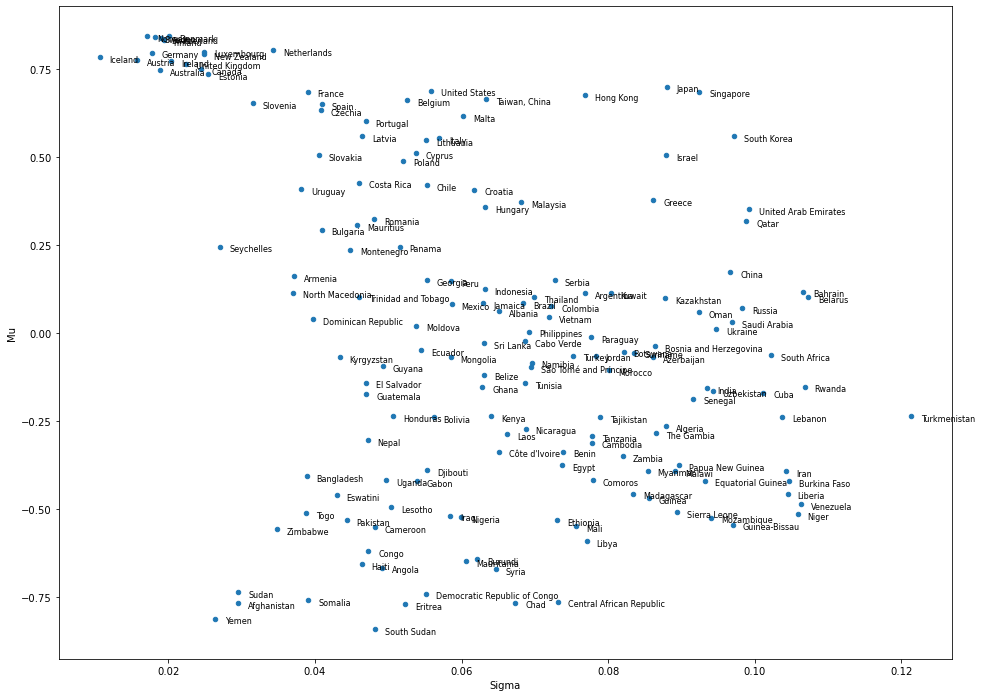

In [21]:
from matplotlib import cm

fig, ax = plt.subplots()

cmap = cm.get_cmap('Spectral')

Sigma_Mu_df.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (16,12))

for k, v in Sigma_Mu_df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='black')

In [22]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['Iceland', 'Norway']
PKF_2: ['Austria', 'Denmark', 'Germany', 'Sweden']
PKF_3: ['Australia', 'Switzerland']
PKF_4: ['Finland']
PKF_5: ['Ireland', 'Luxembourg', 'Netherlands']
PKF_6: ['New Zealand', 'United Kingdom']
PKF_7: ['Canada']
PKF_8: ['Estonia']
PKF_9: ['France', 'Japan', 'Seychelles', 'Slovenia', 'United States', 'Yemen']
PKF_10: ['Armenia', 'Belgium', 'Czechia', 'Hong Kong', 'North Macedonia', 'Singapore', 'Slovakia', 'Spain', 'Sudan', 'Taiwan, China', 'Uruguay', 'Zimbabwe']
PKF_11: ['Afghanistan', 'Bangladesh', 'Bulgaria', 'Costa Rica', 'Dominican Republic', 'Latvia', 'Malta', 'Mauritius', 'Portugal', 'Togo']
PKF_12: ['Cyprus', 'Eswatini', 'Italy', 'Kyrgyzstan', 'Lithuania', 'Montenegro', 'Poland', 'Romania', 'Somalia', 'South Korea']
PKF_13: ['Chile', 'Israel', 'Pakistan', 'Panama', 'Trinidad and Tobago']
PKF_14: ['Croatia', 'El Salvador', 'Georgia', 'Guyana', 'Haiti', 'Moldova']
PKF_15: ['Ecuador', 'Greece', 'Guatemala', 'Hungary', 'Malaysia', 'Peru']
PKF_16: ['Chin

In [23]:
from PROMETHEE import optimize_PROM2_original, optimize_newconstraint

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[PKF[fr]]) # get alternatives within frontier fr
        
        M, resultado = optimize_PROM2_original(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')
        
        #print(f'local_ef = {local_ef[unit, fr]}')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 1, fronteira 6: resolvido.
alternative 1, fronteira 7: resolvido.
alternative 1, fronteira 8: resolvido.
alternative 1, fronteira 9: resolvido.
alternative 1, fronteira 10: resolvido.
alternative 1, fronteira 11: resolvido.
alternative 1, fronteira 12: resolvido.
alternative 1, fronteira 13: resolvido.
alternative 1, fronteira 14: resolvido.
alternative 1, fronteira 15: resolvido.
alternative 1, fronteira 16: resolvido.
alternative 1, fronteira 17: resolvido.
alternative 1, fronteira 18: resolvido.
alternative 1, fronteira 19: resolvido.
alternative 1, fronteira 20: resolvido.
alternative 1, fronteira 21: resolvido.
alternative 1, fronteira 22: resolvido.
alternative 1, fronteira 23: resolvido.
alternative 1, fronteira 24: resolvido.
alternative 1, fronteira 25: resolvido.
alternati

alternative 8, fronteira 5: resolvido.
alternative 8, fronteira 6: resolvido.
alternative 8, fronteira 7: resolvido.
alternative 8, fronteira 8: resolvido.
alternative 8, fronteira 9: resolvido.
alternative 8, fronteira 10: resolvido.
alternative 8, fronteira 11: resolvido.
alternative 8, fronteira 12: resolvido.
alternative 8, fronteira 13: resolvido.
alternative 8, fronteira 14: resolvido.
alternative 8, fronteira 15: resolvido.
alternative 8, fronteira 16: resolvido.
alternative 8, fronteira 17: resolvido.
alternative 8, fronteira 18: resolvido.
alternative 8, fronteira 19: resolvido.
alternative 8, fronteira 20: resolvido.
alternative 8, fronteira 21: resolvido.
alternative 8, fronteira 22: resolvido.
alternative 8, fronteira 23: resolvido.
alternative 8, fronteira 24: resolvido.
alternative 8, fronteira 25: resolvido.
alternative 8, fronteira 26: resolvido.
alternative 8, fronteira 27: resolvido.
alternative 8, fronteira 28: resolvido.
alternative 8, fronteira 29: resolvido.
alter

alternative 15, fronteira 5: resolvido.
alternative 15, fronteira 6: resolvido.
alternative 15, fronteira 7: resolvido.
alternative 15, fronteira 8: resolvido.
alternative 15, fronteira 9: resolvido.
alternative 15, fronteira 10: resolvido.
alternative 15, fronteira 11: resolvido.
alternative 15, fronteira 12: resolvido.
alternative 15, fronteira 13: resolvido.
alternative 15, fronteira 14: resolvido.
alternative 15, fronteira 15: resolvido.
alternative 15, fronteira 16: resolvido.
alternative 15, fronteira 17: resolvido.
alternative 15, fronteira 18: resolvido.
alternative 15, fronteira 19: resolvido.
alternative 15, fronteira 20: resolvido.
alternative 15, fronteira 21: resolvido.
alternative 15, fronteira 22: resolvido.
alternative 15, fronteira 23: resolvido.
alternative 15, fronteira 24: resolvido.
alternative 15, fronteira 25: resolvido.
alternative 15, fronteira 26: resolvido.
alternative 15, fronteira 27: resolvido.
alternative 15, fronteira 28: resolvido.
alternative 15, front

alternative 22, fronteira 4: resolvido.
alternative 22, fronteira 5: resolvido.
alternative 22, fronteira 6: resolvido.
alternative 22, fronteira 7: resolvido.
alternative 22, fronteira 8: resolvido.
alternative 22, fronteira 9: resolvido.
alternative 22, fronteira 10: resolvido.
alternative 22, fronteira 11: resolvido.
alternative 22, fronteira 12: resolvido.
alternative 22, fronteira 13: resolvido.
alternative 22, fronteira 14: resolvido.
alternative 22, fronteira 15: resolvido.
alternative 22, fronteira 16: resolvido.
alternative 22, fronteira 17: resolvido.
alternative 22, fronteira 18: resolvido.
alternative 22, fronteira 19: resolvido.
alternative 22, fronteira 20: resolvido.
alternative 22, fronteira 21: resolvido.
alternative 22, fronteira 22: resolvido.
alternative 22, fronteira 23: resolvido.
alternative 22, fronteira 24: resolvido.
alternative 22, fronteira 25: resolvido.
alternative 22, fronteira 26: resolvido.
alternative 22, fronteira 27: resolvido.
alternative 22, fronte

alternative 29, fronteira 3: resolvido.
alternative 29, fronteira 4: resolvido.
alternative 29, fronteira 5: resolvido.
alternative 29, fronteira 6: resolvido.
alternative 29, fronteira 7: resolvido.
alternative 29, fronteira 8: resolvido.
alternative 29, fronteira 9: resolvido.
alternative 29, fronteira 10: resolvido.
alternative 29, fronteira 11: resolvido.
alternative 29, fronteira 12: resolvido.
alternative 29, fronteira 13: resolvido.
alternative 29, fronteira 14: resolvido.
alternative 29, fronteira 15: resolvido.
alternative 29, fronteira 16: resolvido.
alternative 29, fronteira 17: resolvido.
alternative 29, fronteira 18: resolvido.
alternative 29, fronteira 19: resolvido.
alternative 29, fronteira 20: resolvido.
alternative 29, fronteira 21: resolvido.
alternative 29, fronteira 22: resolvido.
alternative 29, fronteira 23: resolvido.
alternative 29, fronteira 24: resolvido.
alternative 29, fronteira 25: resolvido.
alternative 29, fronteira 26: resolvido.
alternative 29, frontei

alternative 36, fronteira 2: resolvido.
alternative 36, fronteira 3: resolvido.
alternative 36, fronteira 4: resolvido.
alternative 36, fronteira 5: resolvido.
alternative 36, fronteira 6: resolvido.
alternative 36, fronteira 7: resolvido.
alternative 36, fronteira 8: resolvido.
alternative 36, fronteira 9: resolvido.
alternative 36, fronteira 10: resolvido.
alternative 36, fronteira 11: resolvido.
alternative 36, fronteira 12: resolvido.
alternative 36, fronteira 13: resolvido.
alternative 36, fronteira 14: resolvido.
alternative 36, fronteira 15: resolvido.
alternative 36, fronteira 16: resolvido.
alternative 36, fronteira 17: resolvido.
alternative 36, fronteira 18: resolvido.
alternative 36, fronteira 19: resolvido.
alternative 36, fronteira 20: resolvido.
alternative 36, fronteira 21: resolvido.
alternative 36, fronteira 22: resolvido.
alternative 36, fronteira 23: resolvido.
alternative 36, fronteira 24: resolvido.
alternative 36, fronteira 25: resolvido.
alternative 36, fronteir

alternative 43, fronteira 1: resolvido.
alternative 43, fronteira 2: resolvido.
alternative 43, fronteira 3: resolvido.
alternative 43, fronteira 4: resolvido.
alternative 43, fronteira 5: resolvido.
alternative 43, fronteira 6: resolvido.
alternative 43, fronteira 7: resolvido.
alternative 43, fronteira 8: resolvido.
alternative 43, fronteira 9: resolvido.
alternative 43, fronteira 10: resolvido.
alternative 43, fronteira 11: resolvido.
alternative 43, fronteira 12: resolvido.
alternative 43, fronteira 13: resolvido.
alternative 43, fronteira 14: resolvido.
alternative 43, fronteira 15: resolvido.
alternative 43, fronteira 16: resolvido.
alternative 43, fronteira 17: resolvido.
alternative 43, fronteira 18: resolvido.
alternative 43, fronteira 19: resolvido.
alternative 43, fronteira 20: resolvido.
alternative 43, fronteira 21: resolvido.
alternative 43, fronteira 22: resolvido.
alternative 43, fronteira 23: resolvido.
alternative 43, fronteira 24: resolvido.
alternative 43, fronteira

alternative 49, fronteira 29: resolvido.
alternative 50, fronteira 1: resolvido.
alternative 50, fronteira 2: resolvido.
alternative 50, fronteira 3: resolvido.
alternative 50, fronteira 4: resolvido.
alternative 50, fronteira 5: resolvido.
alternative 50, fronteira 6: resolvido.
alternative 50, fronteira 7: resolvido.
alternative 50, fronteira 8: resolvido.
alternative 50, fronteira 9: resolvido.
alternative 50, fronteira 10: resolvido.
alternative 50, fronteira 11: resolvido.
alternative 50, fronteira 12: resolvido.
alternative 50, fronteira 13: resolvido.
alternative 50, fronteira 14: resolvido.
alternative 50, fronteira 15: resolvido.
alternative 50, fronteira 16: resolvido.
alternative 50, fronteira 17: resolvido.
alternative 50, fronteira 18: resolvido.
alternative 50, fronteira 19: resolvido.
alternative 50, fronteira 20: resolvido.
alternative 50, fronteira 21: resolvido.
alternative 50, fronteira 22: resolvido.
alternative 50, fronteira 23: resolvido.
alternative 50, fronteira

alternative 56, fronteira 28: resolvido.
alternative 56, fronteira 29: resolvido.
alternative 57, fronteira 1: resolvido.
alternative 57, fronteira 2: resolvido.
alternative 57, fronteira 3: resolvido.
alternative 57, fronteira 4: resolvido.
alternative 57, fronteira 5: resolvido.
alternative 57, fronteira 6: resolvido.
alternative 57, fronteira 7: resolvido.
alternative 57, fronteira 8: resolvido.
alternative 57, fronteira 9: resolvido.
alternative 57, fronteira 10: resolvido.
alternative 57, fronteira 11: resolvido.
alternative 57, fronteira 12: resolvido.
alternative 57, fronteira 13: resolvido.
alternative 57, fronteira 14: resolvido.
alternative 57, fronteira 15: resolvido.
alternative 57, fronteira 16: resolvido.
alternative 57, fronteira 17: resolvido.
alternative 57, fronteira 18: resolvido.
alternative 57, fronteira 19: resolvido.
alternative 57, fronteira 20: resolvido.
alternative 57, fronteira 21: resolvido.
alternative 57, fronteira 22: resolvido.
alternative 57, fronteira

alternative 63, fronteira 27: resolvido.
alternative 63, fronteira 28: resolvido.
alternative 63, fronteira 29: resolvido.
alternative 64, fronteira 1: resolvido.
alternative 64, fronteira 2: resolvido.
alternative 64, fronteira 3: resolvido.
alternative 64, fronteira 4: resolvido.
alternative 64, fronteira 5: resolvido.
alternative 64, fronteira 6: resolvido.
alternative 64, fronteira 7: resolvido.
alternative 64, fronteira 8: resolvido.
alternative 64, fronteira 9: resolvido.
alternative 64, fronteira 10: resolvido.
alternative 64, fronteira 11: resolvido.
alternative 64, fronteira 12: resolvido.
alternative 64, fronteira 13: resolvido.
alternative 64, fronteira 14: resolvido.
alternative 64, fronteira 15: resolvido.
alternative 64, fronteira 16: resolvido.
alternative 64, fronteira 17: resolvido.
alternative 64, fronteira 18: resolvido.
alternative 64, fronteira 19: resolvido.
alternative 64, fronteira 20: resolvido.
alternative 64, fronteira 21: resolvido.
alternative 64, fronteira

alternative 70, fronteira 26: resolvido.
alternative 70, fronteira 27: resolvido.
alternative 70, fronteira 28: resolvido.
alternative 70, fronteira 29: resolvido.
alternative 71, fronteira 1: resolvido.
alternative 71, fronteira 2: resolvido.
alternative 71, fronteira 3: resolvido.
alternative 71, fronteira 4: resolvido.
alternative 71, fronteira 5: resolvido.
alternative 71, fronteira 6: resolvido.
alternative 71, fronteira 7: resolvido.
alternative 71, fronteira 8: resolvido.
alternative 71, fronteira 9: resolvido.
alternative 71, fronteira 10: resolvido.
alternative 71, fronteira 11: resolvido.
alternative 71, fronteira 12: resolvido.
alternative 71, fronteira 13: resolvido.
alternative 71, fronteira 14: resolvido.
alternative 71, fronteira 15: resolvido.
alternative 71, fronteira 16: resolvido.
alternative 71, fronteira 17: resolvido.
alternative 71, fronteira 18: resolvido.
alternative 71, fronteira 19: resolvido.
alternative 71, fronteira 20: resolvido.
alternative 71, fronteira

alternative 77, fronteira 25: resolvido.
alternative 77, fronteira 26: resolvido.
alternative 77, fronteira 27: resolvido.
alternative 77, fronteira 28: resolvido.
alternative 77, fronteira 29: resolvido.
alternative 78, fronteira 1: resolvido.
alternative 78, fronteira 2: resolvido.
alternative 78, fronteira 3: resolvido.
alternative 78, fronteira 4: resolvido.
alternative 78, fronteira 5: resolvido.
alternative 78, fronteira 6: resolvido.
alternative 78, fronteira 7: resolvido.
alternative 78, fronteira 8: resolvido.
alternative 78, fronteira 9: resolvido.
alternative 78, fronteira 10: resolvido.
alternative 78, fronteira 11: resolvido.
alternative 78, fronteira 12: resolvido.
alternative 78, fronteira 13: resolvido.
alternative 78, fronteira 14: resolvido.
alternative 78, fronteira 15: resolvido.
alternative 78, fronteira 16: resolvido.
alternative 78, fronteira 17: resolvido.
alternative 78, fronteira 18: resolvido.
alternative 78, fronteira 19: resolvido.
alternative 78, fronteira

alternative 84, fronteira 24: resolvido.
alternative 84, fronteira 25: resolvido.
alternative 84, fronteira 26: resolvido.
alternative 84, fronteira 27: resolvido.
alternative 84, fronteira 28: resolvido.
alternative 84, fronteira 29: resolvido.
alternative 85, fronteira 1: resolvido.
alternative 85, fronteira 2: resolvido.
alternative 85, fronteira 3: resolvido.
alternative 85, fronteira 4: resolvido.
alternative 85, fronteira 5: resolvido.
alternative 85, fronteira 6: resolvido.
alternative 85, fronteira 7: resolvido.
alternative 85, fronteira 8: resolvido.
alternative 85, fronteira 9: resolvido.
alternative 85, fronteira 10: resolvido.
alternative 85, fronteira 11: resolvido.
alternative 85, fronteira 12: resolvido.
alternative 85, fronteira 13: resolvido.
alternative 85, fronteira 14: resolvido.
alternative 85, fronteira 15: resolvido.
alternative 85, fronteira 16: resolvido.
alternative 85, fronteira 17: resolvido.
alternative 85, fronteira 18: resolvido.
alternative 85, fronteira

alternative 91, fronteira 23: resolvido.
alternative 91, fronteira 24: resolvido.
alternative 91, fronteira 25: resolvido.
alternative 91, fronteira 26: resolvido.
alternative 91, fronteira 27: resolvido.
alternative 91, fronteira 28: resolvido.
alternative 91, fronteira 29: resolvido.
alternative 92, fronteira 1: resolvido.
alternative 92, fronteira 2: resolvido.
alternative 92, fronteira 3: resolvido.
alternative 92, fronteira 4: resolvido.
alternative 92, fronteira 5: resolvido.
alternative 92, fronteira 6: resolvido.
alternative 92, fronteira 7: resolvido.
alternative 92, fronteira 8: resolvido.
alternative 92, fronteira 9: resolvido.
alternative 92, fronteira 10: resolvido.
alternative 92, fronteira 11: resolvido.
alternative 92, fronteira 12: resolvido.
alternative 92, fronteira 13: resolvido.
alternative 92, fronteira 14: resolvido.
alternative 92, fronteira 15: resolvido.
alternative 92, fronteira 16: resolvido.
alternative 92, fronteira 17: resolvido.
alternative 92, fronteira

alternative 98, fronteira 22: resolvido.
alternative 98, fronteira 23: resolvido.
alternative 98, fronteira 24: resolvido.
alternative 98, fronteira 25: resolvido.
alternative 98, fronteira 26: resolvido.
alternative 98, fronteira 27: resolvido.
alternative 98, fronteira 28: resolvido.
alternative 98, fronteira 29: resolvido.
alternative 99, fronteira 1: resolvido.
alternative 99, fronteira 2: resolvido.
alternative 99, fronteira 3: resolvido.
alternative 99, fronteira 4: resolvido.
alternative 99, fronteira 5: resolvido.
alternative 99, fronteira 6: resolvido.
alternative 99, fronteira 7: resolvido.
alternative 99, fronteira 8: resolvido.
alternative 99, fronteira 9: resolvido.
alternative 99, fronteira 10: resolvido.
alternative 99, fronteira 11: resolvido.
alternative 99, fronteira 12: resolvido.
alternative 99, fronteira 13: resolvido.
alternative 99, fronteira 14: resolvido.
alternative 99, fronteira 15: resolvido.
alternative 99, fronteira 16: resolvido.
alternative 99, fronteira

alternative 105, fronteira 17: resolvido.
alternative 105, fronteira 18: resolvido.
alternative 105, fronteira 19: resolvido.
alternative 105, fronteira 20: resolvido.
alternative 105, fronteira 21: resolvido.
alternative 105, fronteira 22: resolvido.
alternative 105, fronteira 23: resolvido.
alternative 105, fronteira 24: resolvido.
alternative 105, fronteira 25: resolvido.
alternative 105, fronteira 26: resolvido.
alternative 105, fronteira 27: resolvido.
alternative 105, fronteira 28: resolvido.
alternative 105, fronteira 29: resolvido.
alternative 106, fronteira 1: resolvido.
alternative 106, fronteira 2: resolvido.
alternative 106, fronteira 3: resolvido.
alternative 106, fronteira 4: resolvido.
alternative 106, fronteira 5: resolvido.
alternative 106, fronteira 6: resolvido.
alternative 106, fronteira 7: resolvido.
alternative 106, fronteira 8: resolvido.
alternative 106, fronteira 9: resolvido.
alternative 106, fronteira 10: resolvido.
alternative 106, fronteira 11: resolvido.
a

alternative 112, fronteira 11: resolvido.
alternative 112, fronteira 12: resolvido.
alternative 112, fronteira 13: resolvido.
alternative 112, fronteira 14: resolvido.
alternative 112, fronteira 15: resolvido.
alternative 112, fronteira 16: resolvido.
alternative 112, fronteira 17: resolvido.
alternative 112, fronteira 18: resolvido.
alternative 112, fronteira 19: resolvido.
alternative 112, fronteira 20: resolvido.
alternative 112, fronteira 21: resolvido.
alternative 112, fronteira 22: resolvido.
alternative 112, fronteira 23: resolvido.
alternative 112, fronteira 24: resolvido.
alternative 112, fronteira 25: resolvido.
alternative 112, fronteira 26: resolvido.
alternative 112, fronteira 27: resolvido.
alternative 112, fronteira 28: resolvido.
alternative 112, fronteira 29: resolvido.
alternative 113, fronteira 1: resolvido.
alternative 113, fronteira 2: resolvido.
alternative 113, fronteira 3: resolvido.
alternative 113, fronteira 4: resolvido.
alternative 113, fronteira 5: resolvid

alternative 119, fronteira 5: resolvido.
alternative 119, fronteira 6: resolvido.
alternative 119, fronteira 7: resolvido.
alternative 119, fronteira 8: resolvido.
alternative 119, fronteira 9: resolvido.
alternative 119, fronteira 10: resolvido.
alternative 119, fronteira 11: resolvido.
alternative 119, fronteira 12: resolvido.
alternative 119, fronteira 13: resolvido.
alternative 119, fronteira 14: resolvido.
alternative 119, fronteira 15: resolvido.
alternative 119, fronteira 16: resolvido.
alternative 119, fronteira 17: resolvido.
alternative 119, fronteira 18: resolvido.
alternative 119, fronteira 19: resolvido.
alternative 119, fronteira 20: resolvido.
alternative 119, fronteira 21: resolvido.
alternative 119, fronteira 22: resolvido.
alternative 119, fronteira 23: resolvido.
alternative 119, fronteira 24: resolvido.
alternative 119, fronteira 25: resolvido.
alternative 119, fronteira 26: resolvido.
alternative 119, fronteira 27: resolvido.
alternative 119, fronteira 28: resolvid

alternative 125, fronteira 28: resolvido.
alternative 125, fronteira 29: resolvido.
alternative 126, fronteira 1: resolvido.
alternative 126, fronteira 2: resolvido.
alternative 126, fronteira 3: resolvido.
alternative 126, fronteira 4: resolvido.
alternative 126, fronteira 5: resolvido.
alternative 126, fronteira 6: resolvido.
alternative 126, fronteira 7: resolvido.
alternative 126, fronteira 8: resolvido.
alternative 126, fronteira 9: resolvido.
alternative 126, fronteira 10: resolvido.
alternative 126, fronteira 11: resolvido.
alternative 126, fronteira 12: resolvido.
alternative 126, fronteira 13: resolvido.
alternative 126, fronteira 14: resolvido.
alternative 126, fronteira 15: resolvido.
alternative 126, fronteira 16: resolvido.
alternative 126, fronteira 17: resolvido.
alternative 126, fronteira 18: resolvido.
alternative 126, fronteira 19: resolvido.
alternative 126, fronteira 20: resolvido.
alternative 126, fronteira 21: resolvido.
alternative 126, fronteira 22: resolvido.
a

alternative 132, fronteira 22: resolvido.
alternative 132, fronteira 23: resolvido.
alternative 132, fronteira 24: resolvido.
alternative 132, fronteira 25: resolvido.
alternative 132, fronteira 26: resolvido.
alternative 132, fronteira 27: resolvido.
alternative 132, fronteira 28: resolvido.
alternative 132, fronteira 29: resolvido.
alternative 133, fronteira 1: resolvido.
alternative 133, fronteira 2: resolvido.
alternative 133, fronteira 3: resolvido.
alternative 133, fronteira 4: resolvido.
alternative 133, fronteira 5: resolvido.
alternative 133, fronteira 6: resolvido.
alternative 133, fronteira 7: resolvido.
alternative 133, fronteira 8: resolvido.
alternative 133, fronteira 9: resolvido.
alternative 133, fronteira 10: resolvido.
alternative 133, fronteira 11: resolvido.
alternative 133, fronteira 12: resolvido.
alternative 133, fronteira 13: resolvido.
alternative 133, fronteira 14: resolvido.
alternative 133, fronteira 15: resolvido.
alternative 133, fronteira 16: resolvido.
a

alternative 139, fronteira 16: resolvido.
alternative 139, fronteira 17: resolvido.
alternative 139, fronteira 18: resolvido.
alternative 139, fronteira 19: resolvido.
alternative 139, fronteira 20: resolvido.
alternative 139, fronteira 21: resolvido.
alternative 139, fronteira 22: resolvido.
alternative 139, fronteira 23: resolvido.
alternative 139, fronteira 24: resolvido.
alternative 139, fronteira 25: resolvido.
alternative 139, fronteira 26: resolvido.
alternative 139, fronteira 27: resolvido.
alternative 139, fronteira 28: resolvido.
alternative 139, fronteira 29: resolvido.
alternative 140, fronteira 1: resolvido.
alternative 140, fronteira 2: resolvido.
alternative 140, fronteira 3: resolvido.
alternative 140, fronteira 4: resolvido.
alternative 140, fronteira 5: resolvido.
alternative 140, fronteira 6: resolvido.
alternative 140, fronteira 7: resolvido.
alternative 140, fronteira 8: resolvido.
alternative 140, fronteira 9: resolvido.
alternative 140, fronteira 10: resolvido.
a

alternative 146, fronteira 10: resolvido.
alternative 146, fronteira 11: resolvido.
alternative 146, fronteira 12: resolvido.
alternative 146, fronteira 13: resolvido.
alternative 146, fronteira 14: resolvido.
alternative 146, fronteira 15: resolvido.
alternative 146, fronteira 16: resolvido.
alternative 146, fronteira 17: resolvido.
alternative 146, fronteira 18: resolvido.
alternative 146, fronteira 19: resolvido.
alternative 146, fronteira 20: resolvido.
alternative 146, fronteira 21: resolvido.
alternative 146, fronteira 22: resolvido.
alternative 146, fronteira 23: resolvido.
alternative 146, fronteira 24: resolvido.
alternative 146, fronteira 25: resolvido.
alternative 146, fronteira 26: resolvido.
alternative 146, fronteira 27: resolvido.
alternative 146, fronteira 28: resolvido.
alternative 146, fronteira 29: resolvido.
alternative 147, fronteira 1: resolvido.
alternative 147, fronteira 2: resolvido.
alternative 147, fronteira 3: resolvido.
alternative 147, fronteira 4: resolvi

alternative 153, fronteira 4: resolvido.
alternative 153, fronteira 5: resolvido.
alternative 153, fronteira 6: resolvido.
alternative 153, fronteira 7: resolvido.
alternative 153, fronteira 8: resolvido.
alternative 153, fronteira 9: resolvido.
alternative 153, fronteira 10: resolvido.
alternative 153, fronteira 11: resolvido.
alternative 153, fronteira 12: resolvido.
alternative 153, fronteira 13: resolvido.
alternative 153, fronteira 14: resolvido.
alternative 153, fronteira 15: resolvido.
alternative 153, fronteira 16: resolvido.
alternative 153, fronteira 17: resolvido.
alternative 153, fronteira 18: resolvido.
alternative 153, fronteira 19: resolvido.
alternative 153, fronteira 20: resolvido.
alternative 153, fronteira 21: resolvido.
alternative 153, fronteira 22: resolvido.
alternative 153, fronteira 23: resolvido.
alternative 153, fronteira 24: resolvido.
alternative 153, fronteira 25: resolvido.
alternative 153, fronteira 26: resolvido.
alternative 153, fronteira 27: resolvido

alternative 159, fronteira 27: resolvido.
alternative 159, fronteira 28: resolvido.
alternative 159, fronteira 29: resolvido.
alternative 160, fronteira 1: resolvido.
alternative 160, fronteira 2: resolvido.
alternative 160, fronteira 3: resolvido.
alternative 160, fronteira 4: resolvido.
alternative 160, fronteira 5: resolvido.
alternative 160, fronteira 6: resolvido.
alternative 160, fronteira 7: resolvido.
alternative 160, fronteira 8: resolvido.
alternative 160, fronteira 9: resolvido.
alternative 160, fronteira 10: resolvido.
alternative 160, fronteira 11: resolvido.
alternative 160, fronteira 12: resolvido.
alternative 160, fronteira 13: resolvido.
alternative 160, fronteira 14: resolvido.
alternative 160, fronteira 15: resolvido.
alternative 160, fronteira 16: resolvido.
alternative 160, fronteira 17: resolvido.
alternative 160, fronteira 18: resolvido.
alternative 160, fronteira 19: resolvido.
alternative 160, fronteira 20: resolvido.
alternative 160, fronteira 21: resolvido.
a

alternative 166, fronteira 21: resolvido.
alternative 166, fronteira 22: resolvido.
alternative 166, fronteira 23: resolvido.
alternative 166, fronteira 24: resolvido.
alternative 166, fronteira 25: resolvido.
alternative 166, fronteira 26: resolvido.
alternative 166, fronteira 27: resolvido.
alternative 166, fronteira 28: resolvido.
alternative 166, fronteira 29: resolvido.
alternative 167, fronteira 1: resolvido.
alternative 167, fronteira 2: resolvido.
alternative 167, fronteira 3: resolvido.
alternative 167, fronteira 4: resolvido.
alternative 167, fronteira 5: resolvido.
alternative 167, fronteira 6: resolvido.
alternative 167, fronteira 7: resolvido.
alternative 167, fronteira 8: resolvido.
alternative 167, fronteira 9: resolvido.
alternative 167, fronteira 10: resolvido.
alternative 167, fronteira 11: resolvido.
alternative 167, fronteira 12: resolvido.
alternative 167, fronteira 13: resolvido.
alternative 167, fronteira 14: resolvido.
alternative 167, fronteira 15: resolvido.
a

In [24]:
global_ef = np.sum(local_ef, axis = 1)
results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results = results.assign(Position = [i+1 for i in range(results.shape[0])])
results.loc["South Sudan"]

Global Efficiency      0.046463
Position             118.000000
Name: South Sudan, dtype: float64

In [25]:
global_ef_new = np.sum(local_ef_new, axis = 1)
results_new = pd.DataFrame({"Global Efficiency": global_ef_new}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results_new = results_new.assign(Position = [i+1 for i in range(results.shape[0])])
results_new.loc["South Sudan"]

Global Efficiency    -21.914981
Position             167.000000
Name: South Sudan, dtype: float64

In [26]:
#PROMETHEE I PARA FLUXO POSITIVO

In [27]:
X = np.array(dados) # decision matrix
m, n = X.shape
q = np.array([5 for j in range (n)]) # indiference thresholds vector
p = np.array([10 for j in range (n)]) # preference thresholds vector
s_curve = [0 for j in range (n)]
pref = [5 for j in range (n)]
w = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights

In [29]:
# Aplica o PROMETHEE_1 ao nosso conjunto de dados

pos_flows = PROMETHEE_2(Decision_Matrix = X, q_thresholds=q, p_thresholds= p, scurve_thresholds = s_curve, weights = w, pref_functions= pref)[2]


In [30]:
pd.DataFrame(pos_flows, index=dados.index).loc["Brazil"]

0    0.335865
Name: Brazil, dtype: float64

In [33]:
n_simulations = 30

W = np.zeros(shape = (n, n_simulations))
P = np.zeros(shape = (n, n_simulations))
Q = np.zeros(shape = (n, n_simulations))

Net_Flows = np.zeros(shape = (m, n_simulations))
Pos_Flows = np.zeros(shape = (m, n_simulations))
Neg_Flows = np.zeros(shape = (m, n_simulations))
results = [[] for s in range (n_simulations)]

# Usaremos sempre a função de preferência do tipo 5
s_curve = [0 for j in range (n)] 
pref = [5 for j in range (n)]

for s in range (n_simulations):
    W [:,s] = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights
    Q [:,s] = np.random.uniform (2,6, n)
    P [:,s] = np.random.uniform (8, 12, n)
    results[s], Net_Flows[:,s], Pos_Flows[:,s], Neg_Flows[:,s] = PROMETHEE_2 (X, Q[:,s], P[:,s], s_curve, W[:,s], pref)
    print (f'simulation {s+1} completed')

simulation 1 completed
simulation 2 completed
simulation 3 completed
simulation 4 completed
simulation 5 completed
simulation 6 completed
simulation 7 completed
simulation 8 completed
simulation 9 completed
simulation 10 completed
simulation 11 completed
simulation 12 completed
simulation 13 completed
simulation 14 completed
simulation 15 completed
simulation 16 completed
simulation 17 completed
simulation 18 completed
simulation 19 completed
simulation 20 completed
simulation 21 completed
simulation 22 completed
simulation 23 completed
simulation 24 completed
simulation 25 completed
simulation 26 completed
simulation 27 completed
simulation 28 completed
simulation 29 completed
simulation 30 completed


In [34]:
mu_pos = np.mean(Pos_Flows, axis=1)
sigma_pos = np.std(Pos_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_pos,"Mu": mu_pos}, index= dados.index)
Sigma_Mu_df.columns

Index(['Sigma', 'Mu'], dtype='object')

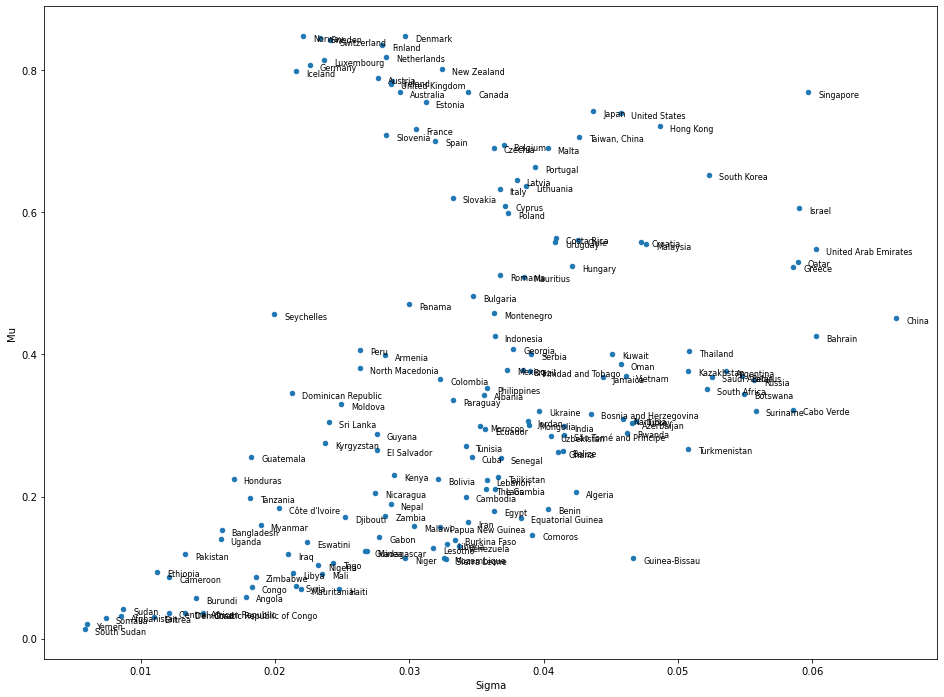

In [35]:
from matplotlib import cm

fig, ax = plt.subplots()

cmap = cm.get_cmap('Spectral')

Sigma_Mu_df.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (16,12))

for k, v in Sigma_Mu_df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='black')

In [36]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['Afghanistan', 'Bangladesh', 'Ethiopia', 'Guatemala', 'Honduras', 'Iceland', 'Norway', 'Pakistan', 'Seychelles', 'Somalia', 'South Sudan', 'Sudan', 'Uganda', 'Yemen']
PKF_2: ['Cameroon', 'Central African Republic', 'Denmark', 'Dominican Republic', 'Eritrea', 'Germany', 'Sweden', 'Tanzania']
PKF_3: ['Angola', 'Burundi', 'Congo', "Côte d'Ivoire", 'Democratic Republic of Congo', 'Luxembourg', 'Myanmar', 'Switzerland', 'Zimbabwe']
PKF_4: ['Austria', 'Chad', 'Eswatini', 'Finland', 'Iraq', 'Kyrgyzstan', 'Moldova', 'Peru', 'Sri Lanka']
PKF_5: ['Armenia', 'Djibouti', 'Libya', 'Netherlands', 'Nigeria', 'North Macedonia', 'Togo']
PKF_6: ['Guinea', 'Guyana', 'Ireland', 'Mali', 'New Zealand', 'Nicaragua', 'Slovenia', 'Syria', 'United Kingdom']
PKF_7: ['Australia', 'El Salvador', 'Madagascar', 'Mauritania']
PKF_8: ['Canada', 'Estonia', 'France', 'Gabon', 'Haiti', 'Kenya', 'Nepal', 'Panama', 'Zambia']
PKF_9: ['Japan', 'Malawi', 'Niger', 'Singapore', 'Spain', 'Taiwan, China']
PKF_10: ['Belgiu

In [37]:
from PROMETHEE import optimize_PROM1_original_pos_flow, optimize_newconstraint_pos_flow

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[PKF[fr]]) # get alternatives within frontier fr
        
        M, resultado = optimize_PROM1_original_pos_flow(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint_pos_flow(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')
        
        #print(f'local_ef = {local_ef[unit, fr]}')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 1, fronteira 6: resolvido.
alternative 1, fronteira 7: resolvido.
alternative 1, fronteira 8: resolvido.
alternative 1, fronteira 9: resolvido.
alternative 1, fronteira 10: resolvido.
alternative 1, fronteira 11: resolvido.
alternative 1, fronteira 12: resolvido.
alternative 1, fronteira 13: resolvido.
alternative 1, fronteira 14: resolvido.
alternative 1, fronteira 15: resolvido.
alternative 1, fronteira 16: resolvido.
alternative 1, fronteira 17: resolvido.
alternative 1, fronteira 18: resolvido.
alternative 1, fronteira 19: resolvido.
alternative 1, fronteira 20: resolvido.
alternative 1, fronteira 21: resolvido.
alternative 1, fronteira 22: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 

alternative 10, fronteira 10: resolvido.
alternative 10, fronteira 11: resolvido.
alternative 10, fronteira 12: resolvido.
alternative 10, fronteira 13: resolvido.
alternative 10, fronteira 14: resolvido.
alternative 10, fronteira 15: resolvido.
alternative 10, fronteira 16: resolvido.
alternative 10, fronteira 17: resolvido.
alternative 10, fronteira 18: resolvido.
alternative 10, fronteira 19: resolvido.
alternative 10, fronteira 20: resolvido.
alternative 10, fronteira 21: resolvido.
alternative 10, fronteira 22: resolvido.
alternative 11, fronteira 1: resolvido.
alternative 11, fronteira 2: resolvido.
alternative 11, fronteira 3: resolvido.
alternative 11, fronteira 4: resolvido.
alternative 11, fronteira 5: resolvido.
alternative 11, fronteira 6: resolvido.
alternative 11, fronteira 7: resolvido.
alternative 11, fronteira 8: resolvido.
alternative 11, fronteira 9: resolvido.
alternative 11, fronteira 10: resolvido.
alternative 11, fronteira 11: resolvido.
alternative 11, fronteira

alternative 19, fronteira 14: resolvido.
alternative 19, fronteira 15: resolvido.
alternative 19, fronteira 16: resolvido.
alternative 19, fronteira 17: resolvido.
alternative 19, fronteira 18: resolvido.
alternative 19, fronteira 19: resolvido.
alternative 19, fronteira 20: resolvido.
alternative 19, fronteira 21: resolvido.
alternative 19, fronteira 22: resolvido.
alternative 20, fronteira 1: resolvido.
alternative 20, fronteira 2: resolvido.
alternative 20, fronteira 3: resolvido.
alternative 20, fronteira 4: resolvido.
alternative 20, fronteira 5: resolvido.
alternative 20, fronteira 6: resolvido.
alternative 20, fronteira 7: resolvido.
alternative 20, fronteira 8: resolvido.
alternative 20, fronteira 9: resolvido.
alternative 20, fronteira 10: resolvido.
alternative 20, fronteira 11: resolvido.
alternative 20, fronteira 12: resolvido.
alternative 20, fronteira 13: resolvido.
alternative 20, fronteira 14: resolvido.
alternative 20, fronteira 15: resolvido.
alternative 20, fronteira

alternative 28, fronteira 18: resolvido.
alternative 28, fronteira 19: resolvido.
alternative 28, fronteira 20: resolvido.
alternative 28, fronteira 21: resolvido.
alternative 28, fronteira 22: resolvido.
alternative 29, fronteira 1: resolvido.
alternative 29, fronteira 2: resolvido.
alternative 29, fronteira 3: resolvido.
alternative 29, fronteira 4: resolvido.
alternative 29, fronteira 5: resolvido.
alternative 29, fronteira 6: resolvido.
alternative 29, fronteira 7: resolvido.
alternative 29, fronteira 8: resolvido.
alternative 29, fronteira 9: resolvido.
alternative 29, fronteira 10: resolvido.
alternative 29, fronteira 11: resolvido.
alternative 29, fronteira 12: resolvido.
alternative 29, fronteira 13: resolvido.
alternative 29, fronteira 14: resolvido.
alternative 29, fronteira 15: resolvido.
alternative 29, fronteira 16: resolvido.
alternative 29, fronteira 17: resolvido.
alternative 29, fronteira 18: resolvido.
alternative 29, fronteira 19: resolvido.
alternative 29, fronteira

alternative 37, fronteira 22: resolvido.
alternative 38, fronteira 1: resolvido.
alternative 38, fronteira 2: resolvido.
alternative 38, fronteira 3: resolvido.
alternative 38, fronteira 4: resolvido.
alternative 38, fronteira 5: resolvido.
alternative 38, fronteira 6: resolvido.
alternative 38, fronteira 7: resolvido.
alternative 38, fronteira 8: resolvido.
alternative 38, fronteira 9: resolvido.
alternative 38, fronteira 10: resolvido.
alternative 38, fronteira 11: resolvido.
alternative 38, fronteira 12: resolvido.
alternative 38, fronteira 13: resolvido.
alternative 38, fronteira 14: resolvido.
alternative 38, fronteira 15: resolvido.
alternative 38, fronteira 16: resolvido.
alternative 38, fronteira 17: resolvido.
alternative 38, fronteira 18: resolvido.
alternative 38, fronteira 19: resolvido.
alternative 38, fronteira 20: resolvido.
alternative 38, fronteira 21: resolvido.
alternative 38, fronteira 22: resolvido.
alternative 39, fronteira 1: resolvido.
alternative 39, fronteira 

alternative 47, fronteira 4: resolvido.
alternative 47, fronteira 5: resolvido.
alternative 47, fronteira 6: resolvido.
alternative 47, fronteira 7: resolvido.
alternative 47, fronteira 8: resolvido.
alternative 47, fronteira 9: resolvido.
alternative 47, fronteira 10: resolvido.
alternative 47, fronteira 11: resolvido.
alternative 47, fronteira 12: resolvido.
alternative 47, fronteira 13: resolvido.
alternative 47, fronteira 14: resolvido.
alternative 47, fronteira 15: resolvido.
alternative 47, fronteira 16: resolvido.
alternative 47, fronteira 17: resolvido.
alternative 47, fronteira 18: resolvido.
alternative 47, fronteira 19: resolvido.
alternative 47, fronteira 20: resolvido.
alternative 47, fronteira 21: resolvido.
alternative 47, fronteira 22: resolvido.
alternative 48, fronteira 1: resolvido.
alternative 48, fronteira 2: resolvido.
alternative 48, fronteira 3: resolvido.
alternative 48, fronteira 4: resolvido.
alternative 48, fronteira 5: resolvido.
alternative 48, fronteira 6

alternative 56, fronteira 8: resolvido.
alternative 56, fronteira 9: resolvido.
alternative 56, fronteira 10: resolvido.
alternative 56, fronteira 11: resolvido.
alternative 56, fronteira 12: resolvido.
alternative 56, fronteira 13: resolvido.
alternative 56, fronteira 14: resolvido.
alternative 56, fronteira 15: resolvido.
alternative 56, fronteira 16: resolvido.
alternative 56, fronteira 17: resolvido.
alternative 56, fronteira 18: resolvido.
alternative 56, fronteira 19: resolvido.
alternative 56, fronteira 20: resolvido.
alternative 56, fronteira 21: resolvido.
alternative 56, fronteira 22: resolvido.
alternative 57, fronteira 1: resolvido.
alternative 57, fronteira 2: resolvido.
alternative 57, fronteira 3: resolvido.
alternative 57, fronteira 4: resolvido.
alternative 57, fronteira 5: resolvido.
alternative 57, fronteira 6: resolvido.
alternative 57, fronteira 7: resolvido.
alternative 57, fronteira 8: resolvido.
alternative 57, fronteira 9: resolvido.
alternative 57, fronteira 1

alternative 65, fronteira 12: resolvido.
alternative 65, fronteira 13: resolvido.
alternative 65, fronteira 14: resolvido.
alternative 65, fronteira 15: resolvido.
alternative 65, fronteira 16: resolvido.
alternative 65, fronteira 17: resolvido.
alternative 65, fronteira 18: resolvido.
alternative 65, fronteira 19: resolvido.
alternative 65, fronteira 20: resolvido.
alternative 65, fronteira 21: resolvido.
alternative 65, fronteira 22: resolvido.
alternative 66, fronteira 1: resolvido.
alternative 66, fronteira 2: resolvido.
alternative 66, fronteira 3: resolvido.
alternative 66, fronteira 4: resolvido.
alternative 66, fronteira 5: resolvido.
alternative 66, fronteira 6: resolvido.
alternative 66, fronteira 7: resolvido.
alternative 66, fronteira 8: resolvido.
alternative 66, fronteira 9: resolvido.
alternative 66, fronteira 10: resolvido.
alternative 66, fronteira 11: resolvido.
alternative 66, fronteira 12: resolvido.
alternative 66, fronteira 13: resolvido.
alternative 66, fronteira

alternative 74, fronteira 16: resolvido.
alternative 74, fronteira 17: resolvido.
alternative 74, fronteira 18: resolvido.
alternative 74, fronteira 19: resolvido.
alternative 74, fronteira 20: resolvido.
alternative 74, fronteira 21: resolvido.
alternative 74, fronteira 22: resolvido.
alternative 75, fronteira 1: resolvido.
alternative 75, fronteira 2: resolvido.
alternative 75, fronteira 3: resolvido.
alternative 75, fronteira 4: resolvido.
alternative 75, fronteira 5: resolvido.
alternative 75, fronteira 6: resolvido.
alternative 75, fronteira 7: resolvido.
alternative 75, fronteira 8: resolvido.
alternative 75, fronteira 9: resolvido.
alternative 75, fronteira 10: resolvido.
alternative 75, fronteira 11: resolvido.
alternative 75, fronteira 12: resolvido.
alternative 75, fronteira 13: resolvido.
alternative 75, fronteira 14: resolvido.
alternative 75, fronteira 15: resolvido.
alternative 75, fronteira 16: resolvido.
alternative 75, fronteira 17: resolvido.
alternative 75, fronteira

alternative 83, fronteira 20: resolvido.
alternative 83, fronteira 21: resolvido.
alternative 83, fronteira 22: resolvido.
alternative 84, fronteira 1: resolvido.
alternative 84, fronteira 2: resolvido.
alternative 84, fronteira 3: resolvido.
alternative 84, fronteira 4: resolvido.
alternative 84, fronteira 5: resolvido.
alternative 84, fronteira 6: resolvido.
alternative 84, fronteira 7: resolvido.
alternative 84, fronteira 8: resolvido.
alternative 84, fronteira 9: resolvido.
alternative 84, fronteira 10: resolvido.
alternative 84, fronteira 11: resolvido.
alternative 84, fronteira 12: resolvido.
alternative 84, fronteira 13: resolvido.
alternative 84, fronteira 14: resolvido.
alternative 84, fronteira 15: resolvido.
alternative 84, fronteira 16: resolvido.
alternative 84, fronteira 17: resolvido.
alternative 84, fronteira 18: resolvido.
alternative 84, fronteira 19: resolvido.
alternative 84, fronteira 20: resolvido.
alternative 84, fronteira 21: resolvido.
alternative 84, fronteira

alternative 93, fronteira 2: resolvido.
alternative 93, fronteira 3: resolvido.
alternative 93, fronteira 4: resolvido.
alternative 93, fronteira 5: resolvido.
alternative 93, fronteira 6: resolvido.
alternative 93, fronteira 7: resolvido.
alternative 93, fronteira 8: resolvido.
alternative 93, fronteira 9: resolvido.
alternative 93, fronteira 10: resolvido.
alternative 93, fronteira 11: resolvido.
alternative 93, fronteira 12: resolvido.
alternative 93, fronteira 13: resolvido.
alternative 93, fronteira 14: resolvido.
alternative 93, fronteira 15: resolvido.
alternative 93, fronteira 16: resolvido.
alternative 93, fronteira 17: resolvido.
alternative 93, fronteira 18: resolvido.
alternative 93, fronteira 19: resolvido.
alternative 93, fronteira 20: resolvido.
alternative 93, fronteira 21: resolvido.
alternative 93, fronteira 22: resolvido.
alternative 94, fronteira 1: resolvido.
alternative 94, fronteira 2: resolvido.
alternative 94, fronteira 3: resolvido.
alternative 94, fronteira 4

alternative 102, fronteira 5: resolvido.
alternative 102, fronteira 6: resolvido.
alternative 102, fronteira 7: resolvido.
alternative 102, fronteira 8: resolvido.
alternative 102, fronteira 9: resolvido.
alternative 102, fronteira 10: resolvido.
alternative 102, fronteira 11: resolvido.
alternative 102, fronteira 12: resolvido.
alternative 102, fronteira 13: resolvido.
alternative 102, fronteira 14: resolvido.
alternative 102, fronteira 15: resolvido.
alternative 102, fronteira 16: resolvido.
alternative 102, fronteira 17: resolvido.
alternative 102, fronteira 18: resolvido.
alternative 102, fronteira 19: resolvido.
alternative 102, fronteira 20: resolvido.
alternative 102, fronteira 21: resolvido.
alternative 102, fronteira 22: resolvido.
alternative 103, fronteira 1: resolvido.
alternative 103, fronteira 2: resolvido.
alternative 103, fronteira 3: resolvido.
alternative 103, fronteira 4: resolvido.
alternative 103, fronteira 5: resolvido.
alternative 103, fronteira 6: resolvido.
alt

alternative 111, fronteira 4: resolvido.
alternative 111, fronteira 5: resolvido.
alternative 111, fronteira 6: resolvido.
alternative 111, fronteira 7: resolvido.
alternative 111, fronteira 8: resolvido.
alternative 111, fronteira 9: resolvido.
alternative 111, fronteira 10: resolvido.
alternative 111, fronteira 11: resolvido.
alternative 111, fronteira 12: resolvido.
alternative 111, fronteira 13: resolvido.
alternative 111, fronteira 14: resolvido.
alternative 111, fronteira 15: resolvido.
alternative 111, fronteira 16: resolvido.
alternative 111, fronteira 17: resolvido.
alternative 111, fronteira 18: resolvido.
alternative 111, fronteira 19: resolvido.
alternative 111, fronteira 20: resolvido.
alternative 111, fronteira 21: resolvido.
alternative 111, fronteira 22: resolvido.
alternative 112, fronteira 1: resolvido.
alternative 112, fronteira 2: resolvido.
alternative 112, fronteira 3: resolvido.
alternative 112, fronteira 4: resolvido.
alternative 112, fronteira 5: resolvido.
alt

alternative 120, fronteira 3: resolvido.
alternative 120, fronteira 4: resolvido.
alternative 120, fronteira 5: resolvido.
alternative 120, fronteira 6: resolvido.
alternative 120, fronteira 7: resolvido.
alternative 120, fronteira 8: resolvido.
alternative 120, fronteira 9: resolvido.
alternative 120, fronteira 10: resolvido.
alternative 120, fronteira 11: resolvido.
alternative 120, fronteira 12: resolvido.
alternative 120, fronteira 13: resolvido.
alternative 120, fronteira 14: resolvido.
alternative 120, fronteira 15: resolvido.
alternative 120, fronteira 16: resolvido.
alternative 120, fronteira 17: resolvido.
alternative 120, fronteira 18: resolvido.
alternative 120, fronteira 19: resolvido.
alternative 120, fronteira 20: resolvido.
alternative 120, fronteira 21: resolvido.
alternative 120, fronteira 22: resolvido.
alternative 121, fronteira 1: resolvido.
alternative 121, fronteira 2: resolvido.
alternative 121, fronteira 3: resolvido.
alternative 121, fronteira 4: resolvido.
alt

alternative 129, fronteira 2: resolvido.
alternative 129, fronteira 3: resolvido.
alternative 129, fronteira 4: resolvido.
alternative 129, fronteira 5: resolvido.
alternative 129, fronteira 6: resolvido.
alternative 129, fronteira 7: resolvido.
alternative 129, fronteira 8: resolvido.
alternative 129, fronteira 9: resolvido.
alternative 129, fronteira 10: resolvido.
alternative 129, fronteira 11: resolvido.
alternative 129, fronteira 12: resolvido.
alternative 129, fronteira 13: resolvido.
alternative 129, fronteira 14: resolvido.
alternative 129, fronteira 15: resolvido.
alternative 129, fronteira 16: resolvido.
alternative 129, fronteira 17: resolvido.
alternative 129, fronteira 18: resolvido.
alternative 129, fronteira 19: resolvido.
alternative 129, fronteira 20: resolvido.
alternative 129, fronteira 21: resolvido.
alternative 129, fronteira 22: resolvido.
alternative 130, fronteira 1: resolvido.
alternative 130, fronteira 2: resolvido.
alternative 130, fronteira 3: resolvido.
alt

alternative 138, fronteira 1: resolvido.
alternative 138, fronteira 2: resolvido.
alternative 138, fronteira 3: resolvido.
alternative 138, fronteira 4: resolvido.
alternative 138, fronteira 5: resolvido.
alternative 138, fronteira 6: resolvido.
alternative 138, fronteira 7: resolvido.
alternative 138, fronteira 8: resolvido.
alternative 138, fronteira 9: resolvido.
alternative 138, fronteira 10: resolvido.
alternative 138, fronteira 11: resolvido.
alternative 138, fronteira 12: resolvido.
alternative 138, fronteira 13: resolvido.
alternative 138, fronteira 14: resolvido.
alternative 138, fronteira 15: resolvido.
alternative 138, fronteira 16: resolvido.
alternative 138, fronteira 17: resolvido.
alternative 138, fronteira 18: resolvido.
alternative 138, fronteira 19: resolvido.
alternative 138, fronteira 20: resolvido.
alternative 138, fronteira 21: resolvido.
alternative 138, fronteira 22: resolvido.
alternative 139, fronteira 1: resolvido.
alternative 139, fronteira 2: resolvido.
alt

alternative 146, fronteira 22: resolvido.
alternative 147, fronteira 1: resolvido.
alternative 147, fronteira 2: resolvido.
alternative 147, fronteira 3: resolvido.
alternative 147, fronteira 4: resolvido.
alternative 147, fronteira 5: resolvido.
alternative 147, fronteira 6: resolvido.
alternative 147, fronteira 7: resolvido.
alternative 147, fronteira 8: resolvido.
alternative 147, fronteira 9: resolvido.
alternative 147, fronteira 10: resolvido.
alternative 147, fronteira 11: resolvido.
alternative 147, fronteira 12: resolvido.
alternative 147, fronteira 13: resolvido.
alternative 147, fronteira 14: resolvido.
alternative 147, fronteira 15: resolvido.
alternative 147, fronteira 16: resolvido.
alternative 147, fronteira 17: resolvido.
alternative 147, fronteira 18: resolvido.
alternative 147, fronteira 19: resolvido.
alternative 147, fronteira 20: resolvido.
alternative 147, fronteira 21: resolvido.
alternative 147, fronteira 22: resolvido.
alternative 148, fronteira 1: resolvido.
al

alternative 155, fronteira 21: resolvido.
alternative 155, fronteira 22: resolvido.
alternative 156, fronteira 1: resolvido.
alternative 156, fronteira 2: resolvido.
alternative 156, fronteira 3: resolvido.
alternative 156, fronteira 4: resolvido.
alternative 156, fronteira 5: resolvido.
alternative 156, fronteira 6: resolvido.
alternative 156, fronteira 7: resolvido.
alternative 156, fronteira 8: resolvido.
alternative 156, fronteira 9: resolvido.
alternative 156, fronteira 10: resolvido.
alternative 156, fronteira 11: resolvido.
alternative 156, fronteira 12: resolvido.
alternative 156, fronteira 13: resolvido.
alternative 156, fronteira 14: resolvido.
alternative 156, fronteira 15: resolvido.
alternative 156, fronteira 16: resolvido.
alternative 156, fronteira 17: resolvido.
alternative 156, fronteira 18: resolvido.
alternative 156, fronteira 19: resolvido.
alternative 156, fronteira 20: resolvido.
alternative 156, fronteira 21: resolvido.
alternative 156, fronteira 22: resolvido.
a

alternative 164, fronteira 20: resolvido.
alternative 164, fronteira 21: resolvido.
alternative 164, fronteira 22: resolvido.
alternative 165, fronteira 1: resolvido.
alternative 165, fronteira 2: resolvido.
alternative 165, fronteira 3: resolvido.
alternative 165, fronteira 4: resolvido.
alternative 165, fronteira 5: resolvido.
alternative 165, fronteira 6: resolvido.
alternative 165, fronteira 7: resolvido.
alternative 165, fronteira 8: resolvido.
alternative 165, fronteira 9: resolvido.
alternative 165, fronteira 10: resolvido.
alternative 165, fronteira 11: resolvido.
alternative 165, fronteira 12: resolvido.
alternative 165, fronteira 13: resolvido.
alternative 165, fronteira 14: resolvido.
alternative 165, fronteira 15: resolvido.
alternative 165, fronteira 16: resolvido.
alternative 165, fronteira 17: resolvido.
alternative 165, fronteira 18: resolvido.
alternative 165, fronteira 19: resolvido.
alternative 165, fronteira 20: resolvido.
alternative 165, fronteira 21: resolvido.
a

In [38]:
global_ef = np.sum(local_ef, axis = 1)
results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results = results.assign(Position = [i+1 for i in range(results.shape[0])])
results.loc["Yemen"]

Global Efficiency     0.536806
Position             42.000000
Name: Yemen, dtype: float64

In [39]:
global_ef_new = np.sum(local_ef_new, axis = 1)
results_new = pd.DataFrame({"Global Efficiency": global_ef_new}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results_new = results_new.assign(Position = [i+1 for i in range(results.shape[0])])
results_new.loc["Yemen"]

Global Efficiency     -8.978966
Position             166.000000
Name: Yemen, dtype: float64

In [40]:
#PROMETHEE I PARA FLUXO NEGATIVO

In [41]:
X = np.array(dados) # decision matrix
m, n = X.shape
q = np.array([5 for j in range (n)]) # indiference thresholds vector
p = np.array([10 for j in range (n)]) # preference thresholds vector
s_curve = [0 for j in range (n)]
pref = [5 for j in range (n)]
w = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights

In [43]:
# Aplica o PROMETHEE_2 ao nosso conjunto de dados

neg_flows = PROMETHEE_2(Decision_Matrix = X, q_thresholds=q, p_thresholds= p, scurve_thresholds = s_curve, weights = w, pref_functions= pref)[3]

In [44]:
pd.DataFrame(neg_flows, index=dados.index).loc["Brazil"]

0    0.281221
Name: Brazil, dtype: float64

In [46]:
n_simulations = 30

W = np.zeros(shape = (n, n_simulations))
P = np.zeros(shape = (n, n_simulations))
Q = np.zeros(shape = (n, n_simulations))

Net_Flows = np.zeros(shape = (m, n_simulations))
Pos_Flows = np.zeros(shape = (m, n_simulations))
Neg_Flows = np.zeros(shape = (m, n_simulations))
results = [[] for s in range (n_simulations)]

# Usaremos sempre a função de preferência do tipo 5
s_curve = [0 for j in range (n)] 
pref = [5 for j in range (n)]

for s in range (n_simulations):
    W [:,s] = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights
    Q [:,s] = np.random.uniform (2,6, n)
    P [:,s] = np.random.uniform (8, 12, n)
    results[s], Net_Flows[:,s], Pos_Flows[:,s], Neg_Flows[:,s] = PROMETHEE_2 (X, Q[:,s], P[:,s], s_curve, W[:,s], pref)
    print (f'simulation {s+1} completed')

simulation 1 completed
simulation 2 completed
simulation 3 completed
simulation 4 completed
simulation 5 completed
simulation 6 completed
simulation 7 completed
simulation 8 completed
simulation 9 completed
simulation 10 completed
simulation 11 completed
simulation 12 completed
simulation 13 completed
simulation 14 completed
simulation 15 completed
simulation 16 completed
simulation 17 completed
simulation 18 completed
simulation 19 completed
simulation 20 completed
simulation 21 completed
simulation 22 completed
simulation 23 completed
simulation 24 completed
simulation 25 completed
simulation 26 completed
simulation 27 completed
simulation 28 completed
simulation 29 completed
simulation 30 completed


In [48]:
mu_neg = np.mean(Neg_Flows, axis=1)
sigma_neg = np.std(Neg_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_neg,"Mu": mu_neg}, index= dados.index)
Sigma_Mu_df.columns

Index(['Sigma', 'Mu'], dtype='object')

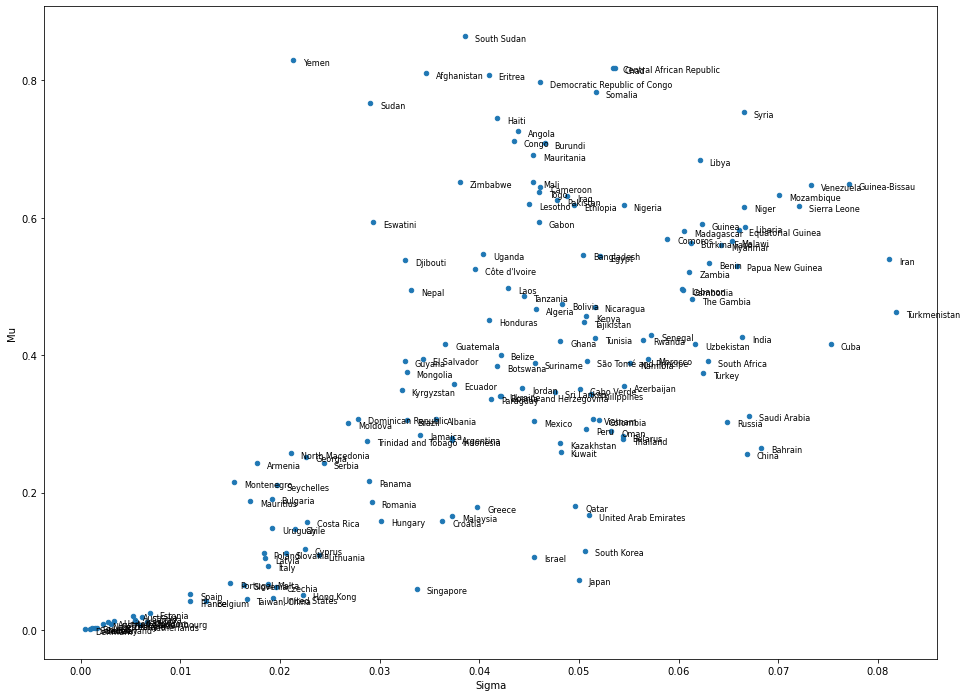

In [49]:
from matplotlib import cm

fig, ax = plt.subplots()

cmap = cm.get_cmap('Spectral')

Sigma_Mu_df.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (16,12))

for k, v in Sigma_Mu_df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='black')

In [50]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] < comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] < comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['Central African Republic', 'Chad', 'Guinea-Bissau', 'Iran', 'South Sudan', 'Syria', 'Turkmenistan']
PKF_2: ['Afghanistan', 'Cuba', 'Democratic Republic of Congo', 'Eritrea', 'Libya', 'Somalia', 'Venezuela', 'Yemen']
PKF_3: ['Angola', 'Burundi', 'Haiti', 'Mozambique', 'Sierra Leone', 'Sudan']
PKF_4: ['Bahrain', 'Cameroon', 'Congo', 'Iraq', 'Liberia', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Saudi Arabia']
PKF_5: ['China', 'Equatorial Guinea', 'Ethiopia', 'Guinea', 'India', 'Pakistan', 'Togo', 'Zimbabwe']
PKF_6: ['Gabon', 'Lesotho', 'Madagascar', 'Malawi', 'Papua New Guinea']
PKF_7: ['Burkina Faso', 'Comoros', 'Eswatini', 'Myanmar', 'Russia']
PKF_8: ['Bangladesh', 'Benin', 'Egypt', 'Uganda']
PKF_9: ["Côte d'Ivoire", 'Djibouti', 'South Africa', 'The Gambia', 'Uzbekistan', 'Zambia']
PKF_10: ['Cambodia', 'Laos', 'Lebanon', 'Turkey']
PKF_11: ['Bolivia', 'Nepal', 'Nicaragua', 'Senegal', 'Tanzania']
PKF_12: ['Algeria', 'Kenya', 'Morocco', 'Rwanda', 'Tunisia']
PKF_13: ['Honduras', 'N

In [51]:
from PROMETHEE import optimize_PROM1_original_neg_flow, optimize_newconstraint_neg_flow

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[PKF[fr]]) # get alternatives within frontier fr
        
        M, resultado = optimize_PROM1_original_neg_flow(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint_neg_flow(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')
        
        #print(f'local_ef = {local_ef[unit, fr]}')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 1, fronteira 6: resolvido.
alternative 1, fronteira 7: resolvido.
alternative 1, fronteira 8: resolvido.
alternative 1, fronteira 9: resolvido.
alternative 1, fronteira 10: resolvido.
alternative 1, fronteira 11: resolvido.
alternative 1, fronteira 12: resolvido.
alternative 1, fronteira 13: resolvido.
alternative 1, fronteira 14: resolvido.
alternative 1, fronteira 15: resolvido.
alternative 1, fronteira 16: resolvido.
alternative 1, fronteira 17: resolvido.
alternative 1, fronteira 18: resolvido.
alternative 1, fronteira 19: resolvido.
alternative 1, fronteira 20: resolvido.
alternative 1, fronteira 21: resolvido.
alternative 1, fronteira 22: resolvido.
alternative 1, fronteira 23: resolvido.
alternative 1, fronteira 24: resolvido.
alternative 1, fronteira 25: resolvido.
alternati

alternative 6, fronteira 8: resolvido.
alternative 6, fronteira 9: resolvido.
alternative 6, fronteira 10: resolvido.
alternative 6, fronteira 11: resolvido.
alternative 6, fronteira 12: resolvido.
alternative 6, fronteira 13: resolvido.
alternative 6, fronteira 14: resolvido.
alternative 6, fronteira 15: resolvido.
alternative 6, fronteira 16: resolvido.
alternative 6, fronteira 17: resolvido.
alternative 6, fronteira 18: resolvido.
alternative 6, fronteira 19: resolvido.
alternative 6, fronteira 20: resolvido.
alternative 6, fronteira 21: resolvido.
alternative 6, fronteira 22: resolvido.
alternative 6, fronteira 23: resolvido.
alternative 6, fronteira 24: resolvido.
alternative 6, fronteira 25: resolvido.
alternative 6, fronteira 26: resolvido.
alternative 6, fronteira 27: resolvido.
alternative 6, fronteira 28: resolvido.
alternative 6, fronteira 29: resolvido.
alternative 6, fronteira 30: resolvido.
alternative 6, fronteira 31: resolvido.
alternative 6, fronteira 32: resolvido.
al

alternative 11, fronteira 13: resolvido.
alternative 11, fronteira 14: resolvido.
alternative 11, fronteira 15: resolvido.
alternative 11, fronteira 16: resolvido.
alternative 11, fronteira 17: resolvido.
alternative 11, fronteira 18: resolvido.
alternative 11, fronteira 19: resolvido.
alternative 11, fronteira 20: resolvido.
alternative 11, fronteira 21: resolvido.
alternative 11, fronteira 22: resolvido.
alternative 11, fronteira 23: resolvido.
alternative 11, fronteira 24: resolvido.
alternative 11, fronteira 25: resolvido.
alternative 11, fronteira 26: resolvido.
alternative 11, fronteira 27: resolvido.
alternative 11, fronteira 28: resolvido.
alternative 11, fronteira 29: resolvido.
alternative 11, fronteira 30: resolvido.
alternative 11, fronteira 31: resolvido.
alternative 11, fronteira 32: resolvido.
alternative 11, fronteira 33: resolvido.
alternative 11, fronteira 34: resolvido.
alternative 11, fronteira 35: resolvido.
alternative 11, fronteira 36: resolvido.
alternative 11, 

alternative 16, fronteira 14: resolvido.
alternative 16, fronteira 15: resolvido.
alternative 16, fronteira 16: resolvido.
alternative 16, fronteira 17: resolvido.
alternative 16, fronteira 18: resolvido.
alternative 16, fronteira 19: resolvido.
alternative 16, fronteira 20: resolvido.
alternative 16, fronteira 21: resolvido.
alternative 16, fronteira 22: resolvido.
alternative 16, fronteira 23: resolvido.
alternative 16, fronteira 24: resolvido.
alternative 16, fronteira 25: resolvido.
alternative 16, fronteira 26: resolvido.
alternative 16, fronteira 27: resolvido.
alternative 16, fronteira 28: resolvido.
alternative 16, fronteira 29: resolvido.
alternative 16, fronteira 30: resolvido.
alternative 16, fronteira 31: resolvido.
alternative 16, fronteira 32: resolvido.
alternative 16, fronteira 33: resolvido.
alternative 16, fronteira 34: resolvido.
alternative 16, fronteira 35: resolvido.
alternative 16, fronteira 36: resolvido.
alternative 16, fronteira 37: resolvido.
alternative 16, 

alternative 21, fronteira 15: resolvido.
alternative 21, fronteira 16: resolvido.
alternative 21, fronteira 17: resolvido.
alternative 21, fronteira 18: resolvido.
alternative 21, fronteira 19: resolvido.
alternative 21, fronteira 20: resolvido.
alternative 21, fronteira 21: resolvido.
alternative 21, fronteira 22: resolvido.
alternative 21, fronteira 23: resolvido.
alternative 21, fronteira 24: resolvido.
alternative 21, fronteira 25: resolvido.
alternative 21, fronteira 26: resolvido.
alternative 21, fronteira 27: resolvido.
alternative 21, fronteira 28: resolvido.
alternative 21, fronteira 29: resolvido.
alternative 21, fronteira 30: resolvido.
alternative 21, fronteira 31: resolvido.
alternative 21, fronteira 32: resolvido.
alternative 21, fronteira 33: resolvido.
alternative 21, fronteira 34: resolvido.
alternative 21, fronteira 35: resolvido.
alternative 21, fronteira 36: resolvido.
alternative 21, fronteira 37: resolvido.
alternative 21, fronteira 38: resolvido.
alternative 21, 

alternative 26, fronteira 16: resolvido.
alternative 26, fronteira 17: resolvido.
alternative 26, fronteira 18: resolvido.
alternative 26, fronteira 19: resolvido.
alternative 26, fronteira 20: resolvido.
alternative 26, fronteira 21: resolvido.
alternative 26, fronteira 22: resolvido.
alternative 26, fronteira 23: resolvido.
alternative 26, fronteira 24: resolvido.
alternative 26, fronteira 25: resolvido.
alternative 26, fronteira 26: resolvido.
alternative 26, fronteira 27: resolvido.
alternative 26, fronteira 28: resolvido.
alternative 26, fronteira 29: resolvido.
alternative 26, fronteira 30: resolvido.
alternative 26, fronteira 31: resolvido.
alternative 26, fronteira 32: resolvido.
alternative 26, fronteira 33: resolvido.
alternative 26, fronteira 34: resolvido.
alternative 26, fronteira 35: resolvido.
alternative 26, fronteira 36: resolvido.
alternative 26, fronteira 37: resolvido.
alternative 26, fronteira 38: resolvido.
alternative 26, fronteira 39: resolvido.
alternative 26, 

alternative 31, fronteira 17: resolvido.
alternative 31, fronteira 18: resolvido.
alternative 31, fronteira 19: resolvido.
alternative 31, fronteira 20: resolvido.
alternative 31, fronteira 21: resolvido.
alternative 31, fronteira 22: resolvido.
alternative 31, fronteira 23: resolvido.
alternative 31, fronteira 24: resolvido.
alternative 31, fronteira 25: resolvido.
alternative 31, fronteira 26: resolvido.
alternative 31, fronteira 27: resolvido.
alternative 31, fronteira 28: resolvido.
alternative 31, fronteira 29: resolvido.
alternative 31, fronteira 30: resolvido.
alternative 31, fronteira 31: resolvido.
alternative 31, fronteira 32: resolvido.
alternative 31, fronteira 33: resolvido.
alternative 31, fronteira 34: resolvido.
alternative 31, fronteira 35: resolvido.
alternative 31, fronteira 36: resolvido.
alternative 31, fronteira 37: resolvido.
alternative 31, fronteira 38: resolvido.
alternative 31, fronteira 39: resolvido.
alternative 31, fronteira 40: resolvido.
alternative 32, 

alternative 36, fronteira 18: resolvido.
alternative 36, fronteira 19: resolvido.
alternative 36, fronteira 20: resolvido.
alternative 36, fronteira 21: resolvido.
alternative 36, fronteira 22: resolvido.
alternative 36, fronteira 23: resolvido.
alternative 36, fronteira 24: resolvido.
alternative 36, fronteira 25: resolvido.
alternative 36, fronteira 26: resolvido.
alternative 36, fronteira 27: resolvido.
alternative 36, fronteira 28: resolvido.
alternative 36, fronteira 29: resolvido.
alternative 36, fronteira 30: resolvido.
alternative 36, fronteira 31: resolvido.
alternative 36, fronteira 32: resolvido.
alternative 36, fronteira 33: resolvido.
alternative 36, fronteira 34: resolvido.
alternative 36, fronteira 35: resolvido.
alternative 36, fronteira 36: resolvido.
alternative 36, fronteira 37: resolvido.
alternative 36, fronteira 38: resolvido.
alternative 36, fronteira 39: resolvido.
alternative 36, fronteira 40: resolvido.
alternative 37, fronteira 1: resolvido.
alternative 37, f

alternative 41, fronteira 19: resolvido.
alternative 41, fronteira 20: resolvido.
alternative 41, fronteira 21: resolvido.
alternative 41, fronteira 22: resolvido.
alternative 41, fronteira 23: resolvido.
alternative 41, fronteira 24: resolvido.
alternative 41, fronteira 25: resolvido.
alternative 41, fronteira 26: resolvido.
alternative 41, fronteira 27: resolvido.
alternative 41, fronteira 28: resolvido.
alternative 41, fronteira 29: resolvido.
alternative 41, fronteira 30: resolvido.
alternative 41, fronteira 31: resolvido.
alternative 41, fronteira 32: resolvido.
alternative 41, fronteira 33: resolvido.
alternative 41, fronteira 34: resolvido.
alternative 41, fronteira 35: resolvido.
alternative 41, fronteira 36: resolvido.
alternative 41, fronteira 37: resolvido.
alternative 41, fronteira 38: resolvido.
alternative 41, fronteira 39: resolvido.
alternative 41, fronteira 40: resolvido.
alternative 42, fronteira 1: resolvido.
alternative 42, fronteira 2: resolvido.
alternative 42, fr

alternative 46, fronteira 20: resolvido.
alternative 46, fronteira 21: resolvido.
alternative 46, fronteira 22: resolvido.
alternative 46, fronteira 23: resolvido.
alternative 46, fronteira 24: resolvido.
alternative 46, fronteira 25: resolvido.
alternative 46, fronteira 26: resolvido.
alternative 46, fronteira 27: resolvido.
alternative 46, fronteira 28: resolvido.
alternative 46, fronteira 29: resolvido.
alternative 46, fronteira 30: resolvido.
alternative 46, fronteira 31: resolvido.
alternative 46, fronteira 32: resolvido.
alternative 46, fronteira 33: resolvido.
alternative 46, fronteira 34: resolvido.
alternative 46, fronteira 35: resolvido.
alternative 46, fronteira 36: resolvido.
alternative 46, fronteira 37: resolvido.
alternative 46, fronteira 38: resolvido.
alternative 46, fronteira 39: resolvido.
alternative 46, fronteira 40: resolvido.
alternative 47, fronteira 1: resolvido.
alternative 47, fronteira 2: resolvido.
alternative 47, fronteira 3: resolvido.
alternative 47, fro

alternative 51, fronteira 21: resolvido.
alternative 51, fronteira 22: resolvido.
alternative 51, fronteira 23: resolvido.
alternative 51, fronteira 24: resolvido.
alternative 51, fronteira 25: resolvido.
alternative 51, fronteira 26: resolvido.
alternative 51, fronteira 27: resolvido.
alternative 51, fronteira 28: resolvido.
alternative 51, fronteira 29: resolvido.
alternative 51, fronteira 30: resolvido.
alternative 51, fronteira 31: resolvido.
alternative 51, fronteira 32: resolvido.
alternative 51, fronteira 33: resolvido.
alternative 51, fronteira 34: resolvido.
alternative 51, fronteira 35: resolvido.
alternative 51, fronteira 36: resolvido.
alternative 51, fronteira 37: resolvido.
alternative 51, fronteira 38: resolvido.
alternative 51, fronteira 39: resolvido.
alternative 51, fronteira 40: resolvido.
alternative 52, fronteira 1: resolvido.
alternative 52, fronteira 2: resolvido.
alternative 52, fronteira 3: resolvido.
alternative 52, fronteira 4: resolvido.
alternative 52, fron

alternative 56, fronteira 22: resolvido.
alternative 56, fronteira 23: resolvido.
alternative 56, fronteira 24: resolvido.
alternative 56, fronteira 25: resolvido.
alternative 56, fronteira 26: resolvido.
alternative 56, fronteira 27: resolvido.
alternative 56, fronteira 28: resolvido.
alternative 56, fronteira 29: resolvido.
alternative 56, fronteira 30: resolvido.
alternative 56, fronteira 31: resolvido.
alternative 56, fronteira 32: resolvido.
alternative 56, fronteira 33: resolvido.
alternative 56, fronteira 34: resolvido.
alternative 56, fronteira 35: resolvido.
alternative 56, fronteira 36: resolvido.
alternative 56, fronteira 37: resolvido.
alternative 56, fronteira 38: resolvido.
alternative 56, fronteira 39: resolvido.
alternative 56, fronteira 40: resolvido.
alternative 57, fronteira 1: resolvido.
alternative 57, fronteira 2: resolvido.
alternative 57, fronteira 3: resolvido.
alternative 57, fronteira 4: resolvido.
alternative 57, fronteira 5: resolvido.
alternative 57, front

alternative 61, fronteira 23: resolvido.
alternative 61, fronteira 24: resolvido.
alternative 61, fronteira 25: resolvido.
alternative 61, fronteira 26: resolvido.
alternative 61, fronteira 27: resolvido.
alternative 61, fronteira 28: resolvido.
alternative 61, fronteira 29: resolvido.
alternative 61, fronteira 30: resolvido.
alternative 61, fronteira 31: resolvido.
alternative 61, fronteira 32: resolvido.
alternative 61, fronteira 33: resolvido.
alternative 61, fronteira 34: resolvido.
alternative 61, fronteira 35: resolvido.
alternative 61, fronteira 36: resolvido.
alternative 61, fronteira 37: resolvido.
alternative 61, fronteira 38: resolvido.
alternative 61, fronteira 39: resolvido.
alternative 61, fronteira 40: resolvido.
alternative 62, fronteira 1: resolvido.
alternative 62, fronteira 2: resolvido.
alternative 62, fronteira 3: resolvido.
alternative 62, fronteira 4: resolvido.
alternative 62, fronteira 5: resolvido.
alternative 62, fronteira 6: resolvido.
alternative 62, fronte

alternative 66, fronteira 24: resolvido.
alternative 66, fronteira 25: resolvido.
alternative 66, fronteira 26: resolvido.
alternative 66, fronteira 27: resolvido.
alternative 66, fronteira 28: resolvido.
alternative 66, fronteira 29: resolvido.
alternative 66, fronteira 30: resolvido.
alternative 66, fronteira 31: resolvido.
alternative 66, fronteira 32: resolvido.
alternative 66, fronteira 33: resolvido.
alternative 66, fronteira 34: resolvido.
alternative 66, fronteira 35: resolvido.
alternative 66, fronteira 36: resolvido.
alternative 66, fronteira 37: resolvido.
alternative 66, fronteira 38: resolvido.
alternative 66, fronteira 39: resolvido.
alternative 66, fronteira 40: resolvido.
alternative 67, fronteira 1: resolvido.
alternative 67, fronteira 2: resolvido.
alternative 67, fronteira 3: resolvido.
alternative 67, fronteira 4: resolvido.
alternative 67, fronteira 5: resolvido.
alternative 67, fronteira 6: resolvido.
alternative 67, fronteira 7: resolvido.
alternative 67, frontei

alternative 71, fronteira 25: resolvido.
alternative 71, fronteira 26: resolvido.
alternative 71, fronteira 27: resolvido.
alternative 71, fronteira 28: resolvido.
alternative 71, fronteira 29: resolvido.
alternative 71, fronteira 30: resolvido.
alternative 71, fronteira 31: resolvido.
alternative 71, fronteira 32: resolvido.
alternative 71, fronteira 33: resolvido.
alternative 71, fronteira 34: resolvido.
alternative 71, fronteira 35: resolvido.
alternative 71, fronteira 36: resolvido.
alternative 71, fronteira 37: resolvido.
alternative 71, fronteira 38: resolvido.
alternative 71, fronteira 39: resolvido.
alternative 71, fronteira 40: resolvido.
alternative 72, fronteira 1: resolvido.
alternative 72, fronteira 2: resolvido.
alternative 72, fronteira 3: resolvido.
alternative 72, fronteira 4: resolvido.
alternative 72, fronteira 5: resolvido.
alternative 72, fronteira 6: resolvido.
alternative 72, fronteira 7: resolvido.
alternative 72, fronteira 8: resolvido.
alternative 72, fronteir

alternative 76, fronteira 26: resolvido.
alternative 76, fronteira 27: resolvido.
alternative 76, fronteira 28: resolvido.
alternative 76, fronteira 29: resolvido.
alternative 76, fronteira 30: resolvido.
alternative 76, fronteira 31: resolvido.
alternative 76, fronteira 32: resolvido.
alternative 76, fronteira 33: resolvido.
alternative 76, fronteira 34: resolvido.
alternative 76, fronteira 35: resolvido.
alternative 76, fronteira 36: resolvido.
alternative 76, fronteira 37: resolvido.
alternative 76, fronteira 38: resolvido.
alternative 76, fronteira 39: resolvido.
alternative 76, fronteira 40: resolvido.
alternative 77, fronteira 1: resolvido.
alternative 77, fronteira 2: resolvido.
alternative 77, fronteira 3: resolvido.
alternative 77, fronteira 4: resolvido.
alternative 77, fronteira 5: resolvido.
alternative 77, fronteira 6: resolvido.
alternative 77, fronteira 7: resolvido.
alternative 77, fronteira 8: resolvido.
alternative 77, fronteira 9: resolvido.
alternative 77, fronteira

alternative 81, fronteira 27: resolvido.
alternative 81, fronteira 28: resolvido.
alternative 81, fronteira 29: resolvido.
alternative 81, fronteira 30: resolvido.
alternative 81, fronteira 31: resolvido.
alternative 81, fronteira 32: resolvido.
alternative 81, fronteira 33: resolvido.
alternative 81, fronteira 34: resolvido.
alternative 81, fronteira 35: resolvido.
alternative 81, fronteira 36: resolvido.
alternative 81, fronteira 37: resolvido.
alternative 81, fronteira 38: resolvido.
alternative 81, fronteira 39: resolvido.
alternative 81, fronteira 40: resolvido.
alternative 82, fronteira 1: resolvido.
alternative 82, fronteira 2: resolvido.
alternative 82, fronteira 3: resolvido.
alternative 82, fronteira 4: resolvido.
alternative 82, fronteira 5: resolvido.
alternative 82, fronteira 6: resolvido.
alternative 82, fronteira 7: resolvido.
alternative 82, fronteira 8: resolvido.
alternative 82, fronteira 9: resolvido.
alternative 82, fronteira 10: resolvido.
alternative 82, fronteira

alternative 86, fronteira 28: resolvido.
alternative 86, fronteira 29: resolvido.
alternative 86, fronteira 30: resolvido.
alternative 86, fronteira 31: resolvido.
alternative 86, fronteira 32: resolvido.
alternative 86, fronteira 33: resolvido.
alternative 86, fronteira 34: resolvido.
alternative 86, fronteira 35: resolvido.
alternative 86, fronteira 36: resolvido.
alternative 86, fronteira 37: resolvido.
alternative 86, fronteira 38: resolvido.
alternative 86, fronteira 39: resolvido.
alternative 86, fronteira 40: resolvido.
alternative 87, fronteira 1: resolvido.
alternative 87, fronteira 2: resolvido.
alternative 87, fronteira 3: resolvido.
alternative 87, fronteira 4: resolvido.
alternative 87, fronteira 5: resolvido.
alternative 87, fronteira 6: resolvido.
alternative 87, fronteira 7: resolvido.
alternative 87, fronteira 8: resolvido.
alternative 87, fronteira 9: resolvido.
alternative 87, fronteira 10: resolvido.
alternative 87, fronteira 11: resolvido.
alternative 87, fronteira

alternative 91, fronteira 29: resolvido.
alternative 91, fronteira 30: resolvido.
alternative 91, fronteira 31: resolvido.
alternative 91, fronteira 32: resolvido.
alternative 91, fronteira 33: resolvido.
alternative 91, fronteira 34: resolvido.
alternative 91, fronteira 35: resolvido.
alternative 91, fronteira 36: resolvido.
alternative 91, fronteira 37: resolvido.
alternative 91, fronteira 38: resolvido.
alternative 91, fronteira 39: resolvido.
alternative 91, fronteira 40: resolvido.
alternative 92, fronteira 1: resolvido.
alternative 92, fronteira 2: resolvido.
alternative 92, fronteira 3: resolvido.
alternative 92, fronteira 4: resolvido.
alternative 92, fronteira 5: resolvido.
alternative 92, fronteira 6: resolvido.
alternative 92, fronteira 7: resolvido.
alternative 92, fronteira 8: resolvido.
alternative 92, fronteira 9: resolvido.
alternative 92, fronteira 10: resolvido.
alternative 92, fronteira 11: resolvido.
alternative 92, fronteira 12: resolvido.
alternative 92, fronteira

alternative 96, fronteira 30: resolvido.
alternative 96, fronteira 31: resolvido.
alternative 96, fronteira 32: resolvido.
alternative 96, fronteira 33: resolvido.
alternative 96, fronteira 34: resolvido.
alternative 96, fronteira 35: resolvido.
alternative 96, fronteira 36: resolvido.
alternative 96, fronteira 37: resolvido.
alternative 96, fronteira 38: resolvido.
alternative 96, fronteira 39: resolvido.
alternative 96, fronteira 40: resolvido.
alternative 97, fronteira 1: resolvido.
alternative 97, fronteira 2: resolvido.
alternative 97, fronteira 3: resolvido.
alternative 97, fronteira 4: resolvido.
alternative 97, fronteira 5: resolvido.
alternative 97, fronteira 6: resolvido.
alternative 97, fronteira 7: resolvido.
alternative 97, fronteira 8: resolvido.
alternative 97, fronteira 9: resolvido.
alternative 97, fronteira 10: resolvido.
alternative 97, fronteira 11: resolvido.
alternative 97, fronteira 12: resolvido.
alternative 97, fronteira 13: resolvido.
alternative 97, fronteira

alternative 101, fronteira 30: resolvido.
alternative 101, fronteira 31: resolvido.
alternative 101, fronteira 32: resolvido.
alternative 101, fronteira 33: resolvido.
alternative 101, fronteira 34: resolvido.
alternative 101, fronteira 35: resolvido.
alternative 101, fronteira 36: resolvido.
alternative 101, fronteira 37: resolvido.
alternative 101, fronteira 38: resolvido.
alternative 101, fronteira 39: resolvido.
alternative 101, fronteira 40: resolvido.
alternative 102, fronteira 1: resolvido.
alternative 102, fronteira 2: resolvido.
alternative 102, fronteira 3: resolvido.
alternative 102, fronteira 4: resolvido.
alternative 102, fronteira 5: resolvido.
alternative 102, fronteira 6: resolvido.
alternative 102, fronteira 7: resolvido.
alternative 102, fronteira 8: resolvido.
alternative 102, fronteira 9: resolvido.
alternative 102, fronteira 10: resolvido.
alternative 102, fronteira 11: resolvido.
alternative 102, fronteira 12: resolvido.
alternative 102, fronteira 13: resolvido.
a

alternative 106, fronteira 27: resolvido.
alternative 106, fronteira 28: resolvido.
alternative 106, fronteira 29: resolvido.
alternative 106, fronteira 30: resolvido.
alternative 106, fronteira 31: resolvido.
alternative 106, fronteira 32: resolvido.
alternative 106, fronteira 33: resolvido.
alternative 106, fronteira 34: resolvido.
alternative 106, fronteira 35: resolvido.
alternative 106, fronteira 36: resolvido.
alternative 106, fronteira 37: resolvido.
alternative 106, fronteira 38: resolvido.
alternative 106, fronteira 39: resolvido.
alternative 106, fronteira 40: resolvido.
alternative 107, fronteira 1: resolvido.
alternative 107, fronteira 2: resolvido.
alternative 107, fronteira 3: resolvido.
alternative 107, fronteira 4: resolvido.
alternative 107, fronteira 5: resolvido.
alternative 107, fronteira 6: resolvido.
alternative 107, fronteira 7: resolvido.
alternative 107, fronteira 8: resolvido.
alternative 107, fronteira 9: resolvido.
alternative 107, fronteira 10: resolvido.
a

alternative 111, fronteira 24: resolvido.
alternative 111, fronteira 25: resolvido.
alternative 111, fronteira 26: resolvido.
alternative 111, fronteira 27: resolvido.
alternative 111, fronteira 28: resolvido.
alternative 111, fronteira 29: resolvido.
alternative 111, fronteira 30: resolvido.
alternative 111, fronteira 31: resolvido.
alternative 111, fronteira 32: resolvido.
alternative 111, fronteira 33: resolvido.
alternative 111, fronteira 34: resolvido.
alternative 111, fronteira 35: resolvido.
alternative 111, fronteira 36: resolvido.
alternative 111, fronteira 37: resolvido.
alternative 111, fronteira 38: resolvido.
alternative 111, fronteira 39: resolvido.
alternative 111, fronteira 40: resolvido.
alternative 112, fronteira 1: resolvido.
alternative 112, fronteira 2: resolvido.
alternative 112, fronteira 3: resolvido.
alternative 112, fronteira 4: resolvido.
alternative 112, fronteira 5: resolvido.
alternative 112, fronteira 6: resolvido.
alternative 112, fronteira 7: resolvido.

alternative 116, fronteira 21: resolvido.
alternative 116, fronteira 22: resolvido.
alternative 116, fronteira 23: resolvido.
alternative 116, fronteira 24: resolvido.
alternative 116, fronteira 25: resolvido.
alternative 116, fronteira 26: resolvido.
alternative 116, fronteira 27: resolvido.
alternative 116, fronteira 28: resolvido.
alternative 116, fronteira 29: resolvido.
alternative 116, fronteira 30: resolvido.
alternative 116, fronteira 31: resolvido.
alternative 116, fronteira 32: resolvido.
alternative 116, fronteira 33: resolvido.
alternative 116, fronteira 34: resolvido.
alternative 116, fronteira 35: resolvido.
alternative 116, fronteira 36: resolvido.
alternative 116, fronteira 37: resolvido.
alternative 116, fronteira 38: resolvido.
alternative 116, fronteira 39: resolvido.
alternative 116, fronteira 40: resolvido.
alternative 117, fronteira 1: resolvido.
alternative 117, fronteira 2: resolvido.
alternative 117, fronteira 3: resolvido.
alternative 117, fronteira 4: resolvi

alternative 121, fronteira 18: resolvido.
alternative 121, fronteira 19: resolvido.
alternative 121, fronteira 20: resolvido.
alternative 121, fronteira 21: resolvido.
alternative 121, fronteira 22: resolvido.
alternative 121, fronteira 23: resolvido.
alternative 121, fronteira 24: resolvido.
alternative 121, fronteira 25: resolvido.
alternative 121, fronteira 26: resolvido.
alternative 121, fronteira 27: resolvido.
alternative 121, fronteira 28: resolvido.
alternative 121, fronteira 29: resolvido.
alternative 121, fronteira 30: resolvido.
alternative 121, fronteira 31: resolvido.
alternative 121, fronteira 32: resolvido.
alternative 121, fronteira 33: resolvido.
alternative 121, fronteira 34: resolvido.
alternative 121, fronteira 35: resolvido.
alternative 121, fronteira 36: resolvido.
alternative 121, fronteira 37: resolvido.
alternative 121, fronteira 38: resolvido.
alternative 121, fronteira 39: resolvido.
alternative 121, fronteira 40: resolvido.
alternative 122, fronteira 1: reso

alternative 126, fronteira 15: resolvido.
alternative 126, fronteira 16: resolvido.
alternative 126, fronteira 17: resolvido.
alternative 126, fronteira 18: resolvido.
alternative 126, fronteira 19: resolvido.
alternative 126, fronteira 20: resolvido.
alternative 126, fronteira 21: resolvido.
alternative 126, fronteira 22: resolvido.
alternative 126, fronteira 23: resolvido.
alternative 126, fronteira 24: resolvido.
alternative 126, fronteira 25: resolvido.
alternative 126, fronteira 26: resolvido.
alternative 126, fronteira 27: resolvido.
alternative 126, fronteira 28: resolvido.
alternative 126, fronteira 29: resolvido.
alternative 126, fronteira 30: resolvido.
alternative 126, fronteira 31: resolvido.
alternative 126, fronteira 32: resolvido.
alternative 126, fronteira 33: resolvido.
alternative 126, fronteira 34: resolvido.
alternative 126, fronteira 35: resolvido.
alternative 126, fronteira 36: resolvido.
alternative 126, fronteira 37: resolvido.
alternative 126, fronteira 38: res

alternative 131, fronteira 12: resolvido.
alternative 131, fronteira 13: resolvido.
alternative 131, fronteira 14: resolvido.
alternative 131, fronteira 15: resolvido.
alternative 131, fronteira 16: resolvido.
alternative 131, fronteira 17: resolvido.
alternative 131, fronteira 18: resolvido.
alternative 131, fronteira 19: resolvido.
alternative 131, fronteira 20: resolvido.
alternative 131, fronteira 21: resolvido.
alternative 131, fronteira 22: resolvido.
alternative 131, fronteira 23: resolvido.
alternative 131, fronteira 24: resolvido.
alternative 131, fronteira 25: resolvido.
alternative 131, fronteira 26: resolvido.
alternative 131, fronteira 27: resolvido.
alternative 131, fronteira 28: resolvido.
alternative 131, fronteira 29: resolvido.
alternative 131, fronteira 30: resolvido.
alternative 131, fronteira 31: resolvido.
alternative 131, fronteira 32: resolvido.
alternative 131, fronteira 33: resolvido.
alternative 131, fronteira 34: resolvido.
alternative 131, fronteira 35: res

alternative 136, fronteira 9: resolvido.
alternative 136, fronteira 10: resolvido.
alternative 136, fronteira 11: resolvido.
alternative 136, fronteira 12: resolvido.
alternative 136, fronteira 13: resolvido.
alternative 136, fronteira 14: resolvido.
alternative 136, fronteira 15: resolvido.
alternative 136, fronteira 16: resolvido.
alternative 136, fronteira 17: resolvido.
alternative 136, fronteira 18: resolvido.
alternative 136, fronteira 19: resolvido.
alternative 136, fronteira 20: resolvido.
alternative 136, fronteira 21: resolvido.
alternative 136, fronteira 22: resolvido.
alternative 136, fronteira 23: resolvido.
alternative 136, fronteira 24: resolvido.
alternative 136, fronteira 25: resolvido.
alternative 136, fronteira 26: resolvido.
alternative 136, fronteira 27: resolvido.
alternative 136, fronteira 28: resolvido.
alternative 136, fronteira 29: resolvido.
alternative 136, fronteira 30: resolvido.
alternative 136, fronteira 31: resolvido.
alternative 136, fronteira 32: reso

alternative 141, fronteira 6: resolvido.
alternative 141, fronteira 7: resolvido.
alternative 141, fronteira 8: resolvido.
alternative 141, fronteira 9: resolvido.
alternative 141, fronteira 10: resolvido.
alternative 141, fronteira 11: resolvido.
alternative 141, fronteira 12: resolvido.
alternative 141, fronteira 13: resolvido.
alternative 141, fronteira 14: resolvido.
alternative 141, fronteira 15: resolvido.
alternative 141, fronteira 16: resolvido.
alternative 141, fronteira 17: resolvido.
alternative 141, fronteira 18: resolvido.
alternative 141, fronteira 19: resolvido.
alternative 141, fronteira 20: resolvido.
alternative 141, fronteira 21: resolvido.
alternative 141, fronteira 22: resolvido.
alternative 141, fronteira 23: resolvido.
alternative 141, fronteira 24: resolvido.
alternative 141, fronteira 25: resolvido.
alternative 141, fronteira 26: resolvido.
alternative 141, fronteira 27: resolvido.
alternative 141, fronteira 28: resolvido.
alternative 141, fronteira 29: resolvi

alternative 146, fronteira 3: resolvido.
alternative 146, fronteira 4: resolvido.
alternative 146, fronteira 5: resolvido.
alternative 146, fronteira 6: resolvido.
alternative 146, fronteira 7: resolvido.
alternative 146, fronteira 8: resolvido.
alternative 146, fronteira 9: resolvido.
alternative 146, fronteira 10: resolvido.
alternative 146, fronteira 11: resolvido.
alternative 146, fronteira 12: resolvido.
alternative 146, fronteira 13: resolvido.
alternative 146, fronteira 14: resolvido.
alternative 146, fronteira 15: resolvido.
alternative 146, fronteira 16: resolvido.
alternative 146, fronteira 17: resolvido.
alternative 146, fronteira 18: resolvido.
alternative 146, fronteira 19: resolvido.
alternative 146, fronteira 20: resolvido.
alternative 146, fronteira 21: resolvido.
alternative 146, fronteira 22: resolvido.
alternative 146, fronteira 23: resolvido.
alternative 146, fronteira 24: resolvido.
alternative 146, fronteira 25: resolvido.
alternative 146, fronteira 26: resolvido.

alternative 150, fronteira 40: resolvido.
alternative 151, fronteira 1: resolvido.
alternative 151, fronteira 2: resolvido.
alternative 151, fronteira 3: resolvido.
alternative 151, fronteira 4: resolvido.
alternative 151, fronteira 5: resolvido.
alternative 151, fronteira 6: resolvido.
alternative 151, fronteira 7: resolvido.
alternative 151, fronteira 8: resolvido.
alternative 151, fronteira 9: resolvido.
alternative 151, fronteira 10: resolvido.
alternative 151, fronteira 11: resolvido.
alternative 151, fronteira 12: resolvido.
alternative 151, fronteira 13: resolvido.
alternative 151, fronteira 14: resolvido.
alternative 151, fronteira 15: resolvido.
alternative 151, fronteira 16: resolvido.
alternative 151, fronteira 17: resolvido.
alternative 151, fronteira 18: resolvido.
alternative 151, fronteira 19: resolvido.
alternative 151, fronteira 20: resolvido.
alternative 151, fronteira 21: resolvido.
alternative 151, fronteira 22: resolvido.
alternative 151, fronteira 23: resolvido.
a

alternative 155, fronteira 37: resolvido.
alternative 155, fronteira 38: resolvido.
alternative 155, fronteira 39: resolvido.
alternative 155, fronteira 40: resolvido.
alternative 156, fronteira 1: resolvido.
alternative 156, fronteira 2: resolvido.
alternative 156, fronteira 3: resolvido.
alternative 156, fronteira 4: resolvido.
alternative 156, fronteira 5: resolvido.
alternative 156, fronteira 6: resolvido.
alternative 156, fronteira 7: resolvido.
alternative 156, fronteira 8: resolvido.
alternative 156, fronteira 9: resolvido.
alternative 156, fronteira 10: resolvido.
alternative 156, fronteira 11: resolvido.
alternative 156, fronteira 12: resolvido.
alternative 156, fronteira 13: resolvido.
alternative 156, fronteira 14: resolvido.
alternative 156, fronteira 15: resolvido.
alternative 156, fronteira 16: resolvido.
alternative 156, fronteira 17: resolvido.
alternative 156, fronteira 18: resolvido.
alternative 156, fronteira 19: resolvido.
alternative 156, fronteira 20: resolvido.
a

alternative 160, fronteira 34: resolvido.
alternative 160, fronteira 35: resolvido.
alternative 160, fronteira 36: resolvido.
alternative 160, fronteira 37: resolvido.
alternative 160, fronteira 38: resolvido.
alternative 160, fronteira 39: resolvido.
alternative 160, fronteira 40: resolvido.
alternative 161, fronteira 1: resolvido.
alternative 161, fronteira 2: resolvido.
alternative 161, fronteira 3: resolvido.
alternative 161, fronteira 4: resolvido.
alternative 161, fronteira 5: resolvido.
alternative 161, fronteira 6: resolvido.
alternative 161, fronteira 7: resolvido.
alternative 161, fronteira 8: resolvido.
alternative 161, fronteira 9: resolvido.
alternative 161, fronteira 10: resolvido.
alternative 161, fronteira 11: resolvido.
alternative 161, fronteira 12: resolvido.
alternative 161, fronteira 13: resolvido.
alternative 161, fronteira 14: resolvido.
alternative 161, fronteira 15: resolvido.
alternative 161, fronteira 16: resolvido.
alternative 161, fronteira 17: resolvido.
a

alternative 165, fronteira 31: resolvido.
alternative 165, fronteira 32: resolvido.
alternative 165, fronteira 33: resolvido.
alternative 165, fronteira 34: resolvido.
alternative 165, fronteira 35: resolvido.
alternative 165, fronteira 36: resolvido.
alternative 165, fronteira 37: resolvido.
alternative 165, fronteira 38: resolvido.
alternative 165, fronteira 39: resolvido.
alternative 165, fronteira 40: resolvido.
alternative 166, fronteira 1: resolvido.
alternative 166, fronteira 2: resolvido.
alternative 166, fronteira 3: resolvido.
alternative 166, fronteira 4: resolvido.
alternative 166, fronteira 5: resolvido.
alternative 166, fronteira 6: resolvido.
alternative 166, fronteira 7: resolvido.
alternative 166, fronteira 8: resolvido.
alternative 166, fronteira 9: resolvido.
alternative 166, fronteira 10: resolvido.
alternative 166, fronteira 11: resolvido.
alternative 166, fronteira 12: resolvido.
alternative 166, fronteira 13: resolvido.
alternative 166, fronteira 14: resolvido.
a

In [52]:
global_ef = np.sum(local_ef, axis = 1)
results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results = results.assign(Position = [i+1 for i in range(results.shape[0])])
results.loc["Yemen"]

Global Efficiency    20.966786
Position              2.000000
Name: Yemen, dtype: float64

In [53]:
global_ef_new = np.sum(local_ef_new, axis = 1)
results_new = pd.DataFrame({"Global Efficiency": global_ef_new}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results_new = results_new.assign(Position = [i+1 for i in range(results.shape[0])])
results_new.loc["Yemen"]

Global Efficiency    20.932063
Position              2.000000
Name: Yemen, dtype: float64

In [54]:
#FORMULAÇÃO 4.2.2.5 - PROMETHEE I - FLUXO POSITIVO E NEGATIVO JUNTOS

In [55]:
X = np.array(dados) # decision matrix
m, n = X.shape
q = np.array([5 for j in range (n)]) # indiference thresholds vector
p = np.array([10 for j in range (n)]) # preference thresholds vector
s_curve = [0 for j in range (n)]
pref = [5 for j in range (n)]
w = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights

In [56]:
# Aplica o PROMETHEE_1 ao nosso conjunto de dados

pos_flows,neg_flows = PROMETHEE_2(Decision_Matrix = X, q_thresholds=q, p_thresholds= p, scurve_thresholds = s_curve, weights = w, pref_functions= pref)[1:3]


In [57]:
pd.DataFrame(pos_flows, index=dados.index).loc["Brazil"]

0    0.141061
Name: Brazil, dtype: float64

In [60]:
pd.DataFrame(neg_flows, index=dados.index).loc["Brazil"]

0    0.416562
Name: Brazil, dtype: float64

In [61]:
n_simulations = 30

W = np.zeros(shape = (n, n_simulations))
P = np.zeros(shape = (n, n_simulations))
Q = np.zeros(shape = (n, n_simulations))

Net_Flows = np.zeros(shape = (m, n_simulations))
Pos_Flows = np.zeros(shape = (m, n_simulations))
Neg_Flows = np.zeros(shape = (m, n_simulations))
results = [[] for s in range (n_simulations)]

# Usaremos sempre a função de preferência do tipo 5
s_curve = [0 for j in range (n)] 
pref = [5 for j in range (n)]

for s in range (n_simulations):
    W [:,s] = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights
    Q [:,s] = np.random.uniform (2,6, n)
    P [:,s] = np.random.uniform (8, 12, n)
    results[s], Net_Flows[:,s], Pos_Flows[:,s], Neg_Flows[:,s] = PROMETHEE_2 (X, Q[:,s], P[:,s], s_curve, W[:,s], pref)
    print (f'simulation {s+1} completed')

simulation 1 completed
simulation 2 completed
simulation 3 completed
simulation 4 completed
simulation 5 completed
simulation 6 completed
simulation 7 completed
simulation 8 completed
simulation 9 completed
simulation 10 completed
simulation 11 completed
simulation 12 completed
simulation 13 completed
simulation 14 completed
simulation 15 completed
simulation 16 completed
simulation 17 completed
simulation 18 completed
simulation 19 completed
simulation 20 completed
simulation 21 completed
simulation 22 completed
simulation 23 completed
simulation 24 completed
simulation 25 completed
simulation 26 completed
simulation 27 completed
simulation 28 completed
simulation 29 completed
simulation 30 completed


In [62]:
mu_pos = np.mean(Pos_Flows, axis=1)
sigma_pos = np.std(Pos_Flows, axis=1)
mu_neg = np.mean(Neg_Flows, axis=1)
sigma_neg = np.std(Neg_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma_pos": sigma_pos,"Mu_pos": mu_pos, "Sigma_neg": sigma_neg,"Mu_neg": mu_neg}, index= dados.index)
Sigma_Mu_df.columns

Index(['Sigma_pos', 'Mu_pos', 'Sigma_neg', 'Mu_neg'], dtype='object')

In [64]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['Burundi', 'Cameroon', 'Ethiopia', 'Iceland', 'Norway', 'Somalia', 'Sudan', 'Togo', 'Yemen']
PKF_2: ['Afghanistan', 'Angola', 'Chad', 'Denmark', 'Eritrea', 'Guatemala', 'Honduras', 'South Sudan', 'Sweden']
PKF_3: ['Central African Republic', 'Congo', 'Democratic Republic of Congo', 'Switzerland', 'Tanzania']
PKF_4: ['Bangladesh', 'Finland', 'Germany']
PKF_5: ['Australia', 'Austria', 'Dominican Republic', 'Ireland', 'Luxembourg', 'Nigeria', 'Pakistan']
PKF_6: ['Haiti', 'Netherlands', 'New Zealand', 'Uganda', 'United Kingdom']
PKF_7: ['Canada', 'Lesotho', 'Mauritania', 'Nicaragua', 'Zimbabwe']
PKF_8: ["Côte d'Ivoire", 'Estonia', 'Madagascar', 'Seychelles', 'Singapore', 'Syria']
PKF_9: ['Eswatini', 'France', 'Guyana', 'Iraq', 'Japan', 'Paraguay', 'Slovenia', 'Spain', 'United States']
PKF_10: ['Armenia', 'Czechia', 'Hong Kong', 'Italy', 'Mali', 'Nepal', 'Panama', 'Slovakia', 'Sri Lanka', 'Taiwan, China']
PKF_11: ['Belgium', 'Kyrgyzstan', 'Moldova', 'North Macedonia', 'Poland', 'Uru

In [65]:
from PROMETHEE import optimize_PROM1_original, optimize_PROM1_newconstraint

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[PKF[fr]]) # get alternatives within frontier fr
        
        M, resultado = optimize_PROM1_original(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_PROM1_newconstraint(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')
        
        #print(f'local_ef = {local_ef[unit, fr]}')


    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 1, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 1, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 1, fron

alternative 1, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 1, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 1, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 2, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 2, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 2, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 3, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 3, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 3, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 4, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 4, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 4, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 5, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 5, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 5, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and b

alternative 6, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 6, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 6, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and blo

alternative 7, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 7, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 7, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and blo

alternative 7, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 8, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 8, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and bl

alternative 8, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 8, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 8, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 9, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 9, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 9, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 10, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 10, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 10, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 11, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 11, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 11, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 12, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 12, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 12, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and

alternative 13, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 13, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 13, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 14, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 14, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 14, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 14, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 14, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 15, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() an

alternative 15, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 15, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 15, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 16, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 16, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 16, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 17, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 17, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 17, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 18, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 18, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 18, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 19, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 19, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 19, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 20, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 20, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 20, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 21, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 21, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 21, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 21, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 21, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 21, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 22, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 22, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 22, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 23, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 23, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 23, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 24, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 24, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 24, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 25, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 25, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 25, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() an

alternative 26, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 26, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 26, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 27, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 27, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 27, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 27, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 28, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 28, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and

alternative 28, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 28, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 28, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 29, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 29, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 29, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 30, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 30, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 30, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 31, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 31, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 31, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 32, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 32, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 32, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and

alternative 33, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 33, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 33, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 34, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 34, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 34, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 34, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 34, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 35, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() an

alternative 35, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 35, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 35, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 36, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 36, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 36, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 37, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 37, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 37, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 38, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 38, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 38, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 39, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 39, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 39, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 40, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 40, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 40, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 41, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 41, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 41, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 41, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 41, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 41, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 42, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 42, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 42, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 43, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 43, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 43, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 44, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 44, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 44, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 45, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 45, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 45, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() an

alternative 46, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 46, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 46, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 47, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 47, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 47, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 47, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 48, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 48, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and

alternative 48, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 48, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 48, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 49, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 49, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 49, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 50, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 50, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 50, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 51, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 51, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 51, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 52, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 52, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 52, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and

alternative 53, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 53, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 53, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 54, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 54, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 54, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 54, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 54, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 55, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() an

alternative 55, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 55, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 55, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 56, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 56, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 56, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 57, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 57, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 57, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 58, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 58, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 58, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 59, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 59, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 59, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 60, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 60, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 60, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 61, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 61, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 61, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 61, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 61, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 61, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 62, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 62, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 62, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 63, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 63, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 63, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 64, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 64, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 64, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 65, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 65, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 65, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() an

alternative 66, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 66, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 66, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 67, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 67, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 67, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 67, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 68, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 68, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and

alternative 68, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 68, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 68, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 69, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 69, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 69, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 70, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 70, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 70, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 71, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 71, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 71, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 72, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 72, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 72, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and

alternative 73, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 73, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 73, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 74, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 74, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 74, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 74, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 74, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 75, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() an

alternative 75, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 75, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 75, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 76, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 76, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 76, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 77, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 77, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 77, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 78, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 78, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 78, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 79, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 79, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 79, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 80, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 80, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 80, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 81, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 81, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 81, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 81, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 81, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 81, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 82, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 82, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 82, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 83, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 83, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 83, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 84, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 84, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 84, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 85, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 85, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 85, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() an

alternative 86, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 86, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 86, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 87, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 87, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 87, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 87, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 88, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 88, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and

alternative 88, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 88, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 88, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 89, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 89, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 89, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 90, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 90, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 90, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 91, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 91, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 91, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 92, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 92, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 92, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and

alternative 93, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 93, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 93, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 94, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 94, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 94, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 94, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 94, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 95, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() an

alternative 95, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 95, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 95, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 96, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 96, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 96, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 97, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 97, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 97, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 98, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 98, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 98, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 99, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 99, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 99, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and 

alternative 100, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 100, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 100, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 101, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 101, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 101, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 101, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 101, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 101, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 102, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 102, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 102, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 103, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 103, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 103, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 104, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 104, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 104, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 105, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 105, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 105, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component()

alternative 106, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 106, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 106, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 107, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 107, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 107, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 107, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 108, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 108, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() 

alternative 108, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 108, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 108, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 109, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 109, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 109, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 110, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 110, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 110, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 111, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 111, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 111, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 112, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 112, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 112, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() 

alternative 113, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 113, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 113, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 114, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 114, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 114, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 114, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 114, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 115, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component()

alternative 115, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 115, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 115, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 116, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 116, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 116, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 117, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 117, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 117, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 118, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 118, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 118, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 119, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 119, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 119, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 120, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 120, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 120, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 121, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 121, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 121, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 121, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 121, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 121, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 122, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 122, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 122, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 123, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 123, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 123, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 124, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 124, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 124, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 125, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 125, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 125, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component()

alternative 126, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 126, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 126, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 127, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 127, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 127, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 127, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 128, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 128, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() 

alternative 128, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 128, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 128, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 129, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 129, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 129, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 130, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 130, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 130, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 131, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 131, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 131, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 132, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 132, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 132, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() 

alternative 133, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 133, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 133, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 134, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 134, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 134, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 134, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 134, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 135, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component()

alternative 135, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 135, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 135, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 136, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 136, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 136, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 137, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 137, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 137, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 138, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 138, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 138, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 139, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 139, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 139, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 140, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 140, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 140, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 141, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 141, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 141, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 141, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 141, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 141, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 142, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 142, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 142, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 143, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 143, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 143, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 144, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 144, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 144, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 145, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 145, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 145, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component()

alternative 146, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 146, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 146, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 147, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 147, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 147, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 147, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 148, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 148, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() 

alternative 148, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 148, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 148, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 149, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 149, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 149, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 150, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 150, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 150, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 151, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 151, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 151, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 152, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 152, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 152, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() 

alternative 153, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 153, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 153, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 154, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 154, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 154, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 154, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 154, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 155, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component()

alternative 155, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 155, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 155, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 156, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 156, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 156, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 157, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 157, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 157, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 158, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 158, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 158, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 159, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 159, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 159, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 160, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 160, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 160, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 161, fronteira 1: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 161, fronteira 2: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 161, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 161, fronteira 21: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 161, fronteira 22: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 161, fronteira 23: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 162, fronteira 18: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 162, fronteira 19: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 162, fronteira 20: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 163, fronteira 15: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 163, fronteira 16: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 163, fronteira 17: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 164, fronteira 12: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 164, fronteira 13: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 164, fronteira 14: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component(

alternative 165, fronteira 9: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 165, fronteira 10: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 165, fronteira 11: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component()

alternative 166, fronteira 6: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 166, fronteira 7: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 166, fronteira 8: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 167, fronteira 3: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 167, fronteira 4: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
alternative 167, fronteira 5: resolvido.
    'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() a

alternative 167, fronteira 23: resolvido.


In [66]:
global_ef = np.sum(local_ef, axis = 1)
results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results = results.assign(Position = [i+1 for i in range(results.shape[0])])
results.loc["Yemen"]

Global Efficiency      NaN
Position             165.0
Name: Yemen, dtype: float64

In [67]:
global_ef_new = np.sum(local_ef_new, axis = 1)
results_new = pd.DataFrame({"Global Efficiency": global_ef_new}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results_new = results_new.assign(Position = [i+1 for i in range(results.shape[0])])
results_new.loc["Yemen"]

Global Efficiency     1.053112
Position             21.000000
Name: Yemen, dtype: float64